In [1]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper')
from __init__ import *
import __init__jupyterlab
importlib.reload(__init__jupyterlab)
from __init__jupyterlab import *

import re 
import tqdm
import pickle
import collections
import itertools
import tables

from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_clst_utils
importlib.reload(CEMBA_clst_utils)
import enhancer_gene_utils 
importlib.reload(enhancer_gene_utils)

<module 'enhancer_gene_utils' from '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper/enhancer_gene_utils.py'>

In [2]:
import datetime
today = datetime.date.today().strftime("%y%m%d")

CORRCOEF_TYPE = 'Spearmanr' # Pearsonr
print(today)

201223


# README

Fixed inputs:
- enhancer list **check**
    - enhancer nearest genes
    - enhancer CICERO
- gene list **check**
- enh-gene pair list **check**

Picked inputs:
- corrs_mc **check**
- corrs_atac **check**

outputs:
- plots and stats of corrs_mc and corrs_atac


## How are corrs_mc and corrs_atac calculated?
- pairs: ```/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv```
- matrices (genes, enhs, matrices): ```/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_nov9```
- knns: ```/cndd2/fangming/projects/miniatlas/results```


## How are other inputs for this notebook generated?
-  ```01.preproc_data_10xv3cells_r100_n935-Dec12.ipynb```
-  ```./correlation_analysis_celllevel/correlation_analysis_celllevel_organize_data-10xv3cells.ipynb```

# config

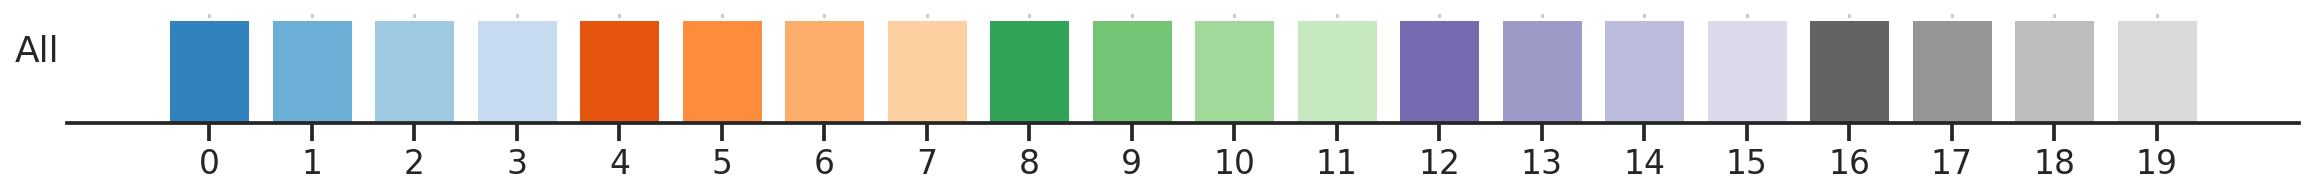

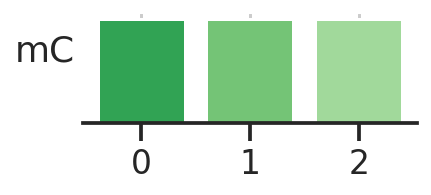

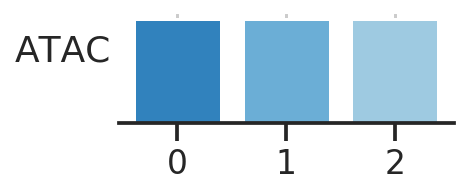

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


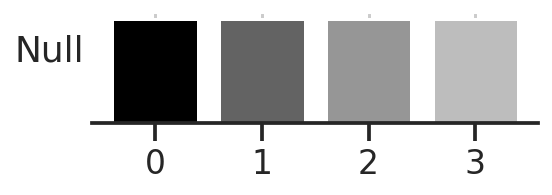

In [3]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

In [4]:
mod_palette = {
    'mc': 'C2',
    'atac': 'C0',
    'null': 'k',
}

mod_palette_comp = {
    'mc': colors_mc,
    'atac': colors_atac,
    'null': colors_null,
}

KB = 1000
def p25(x):
    return np.nanpercentile(x, 25)
def p75(x):
    return np.nanpercentile(x, 75)

In [5]:
def strip_gid_suffix(gid):
    """
    """
    if isinstance(gid, str):
        gid_new = gid.split('.')[0]
    else:
        gid_new = ''
    return gid_new

# data 
- caveats - 
- the genes, enhs, pairs list here may be incomplete; 
- they are tailored to cluster38 version

In [6]:
# genes
# enhs
# to_evals
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/genes_list.tsv'
genes_list = pd.read_csv(f, sep='\t', index_col=False)
print(genes_list.shape)

# enh list
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/enhs_list.tsv'
enh_list = pd.read_csv(f, sep='\t', index_col=False)
print(enh_list.shape)

# pair list
f = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals_appended_201212.tsv' 
to_evals = pd.read_csv(f, sep='\t', index_col=False)
to_evals = to_evals.astype({'dist': np.int, 'enh': np.int, 'is_in_genebody': np.bool_})

print(to_evals.shape)

(31053, 11)
(233514, 7)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(2589994, 4)


In [7]:
gid_to_gname = genes_list.groupby('gid').first()['gene_name'] 
gname_to_gid = genes_list.groupby('gene_name').first()['gid']

def gname_to_gid_nan(name):
    try:
        return gname_to_gid[name]
    except:
        return np.nan

In [8]:
# f = '/cndd2/fangming/projects/scf_enhancers/enhancer_ethan38_200520/ref/annotations_order.tsv'
# clst_annot = pd.read_csv(f, sep='\t').set_index('cluster')['annotation']
# print(clst_annot.shape)
# clst_annot.head()

In [9]:
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/enhancer_nearest_genes.bed'
regions_info = pd.read_csv(f, sep='\t', header=None, dtype={0: str, 4: str}, 
                           names=['chr', 'start', 'end', 
                                  'trpt_chr', 'trpt_start', 'trpt_end', 
                                  'strand', 
                                  'trpt_id', 'trpt_name',
                                  'gene_id', 'gene_name',
                                  'dist',
                                 ]
                          )

print(regions_info.shape)
print(enh_list.shape)
# expand enh_list
enh_list_expand = pd.merge(enh_list, regions_info, on=['chr', 'start', 'end'], how='left')
print(enh_list_expand.shape)
enh_list_expand.head()

(233514, 12)
(233514, 7)
(233514, 16)


,index,chr,start,end,length,chrom,center,trpt_chr,trpt_start,trpt_end,strand,trpt_id,trpt_name,gene_id,gene_name,dist
0,0,chr1,3083769,3083816,47,1,3083792,chr1,3073253,3073254,+,ENSMUST00000193812.1,4933401J01Rik-201,ENSMUSG00000102693.1,4933401J01Rik,10516
1,1,chr1,3112234,3112467,233,1,3112350,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10218
2,2,chr1,3112770,3112986,216,1,3112878,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10754
3,3,chr1,3113717,3114035,318,1,3113876,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,11701
4,4,chr1,3118790,3118935,145,1,3118862,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,16774


In [10]:
# cicero pairs
## enh <-> cicero enh
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/enhancer_cicero_overlap.bed'
enh_cicero_overlap = pd.read_csv(f, sep='\t', 
                                 names=['chr', 'start', 'end', 
                                        'cicero_chr', 'cicero_start', 'cicero_end',
                                        'overlap',
                                       ]) 
print(enh_cicero_overlap.shape)
# restrict to the enhancers in this study
enh_cicero_overlap = pd.merge(enh_cicero_overlap, enh_list[['chr', 'start', 'end', 'index']], 
                                 on=['chr', 'start', 'end'])
print(enh_cicero_overlap.shape)


## cicero enh <-> cicero gene
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/ref/cicero_enhancer_gene_mm10_chr.bed'
cicero_gene_links = pd.read_csv(f, sep='\t', 
                                names=['cicero_chr', 'cicero_start', 'cicero_end', 'cicero_idx', 'cicero_gene']
                               ) 
# restrict to genes in this study
cicero_gene_links['cicero_gid'] = cicero_gene_links['cicero_gene'].apply(gname_to_gid_nan)
print(cicero_gene_links.shape)
cicero_gene_links = cicero_gene_links.dropna()
print(cicero_gene_links.shape)


## merge for enh <-> gene (cicero) (register into the current gene-enh pairs (index))
enh_gene_links_cicero = pd.merge(enh_cicero_overlap, cicero_gene_links, 
                                 on=['cicero_chr', 'cicero_start', 'cicero_end'])
enh_gene_links_cicero = enh_gene_links_cicero[['index', 'cicero_gid']].rename(
                            columns={'cicero_gid': 'gene', 'index': 'enh',})
enh_gene_links_cicero = (pd.merge(enh_gene_links_cicero, to_evals[['gene', 'enh']].reset_index(), 
                                  on=['enh', 'gene']) 
                                .groupby('index').first() # remove dup 
                        )
print(enh_cicero_overlap.shape, 
      cicero_gene_links.shape, 
      enh_gene_links_cicero.shape,
     )
enh_gene_links_cicero.head()

(102287, 7)
(102287, 8)
(1283006, 6)
(990207, 6)
(102287, 8) (990207, 6) (305768, 2)


,enh,gene
index,,
65,147620,ENSMUSG00000000001
68,147628,ENSMUSG00000000001
72,147634,ENSMUSG00000000001
74,147637,ENSMUSG00000000001
76,147643,ENSMUSG00000000001


# Analysis 

In [11]:

# get all clusterings
def get_isub_clstfile(fname):
    """Subsampling index
    """
    pattern = '_sub[0-9]+.tsv.gz' 
    isub = int(re.findall(pattern, fname)[0][len("_sub"):-len('.tsv.gz')])
    return isub 

def get_knn_clstfile(fname):
    """cross-modal knn
    """
    pattern = '_knn[0-9]+_' 
    knn = int(re.findall(pattern, fname)[0][len("_knn"):-len('_')])
    return knn 

f_pattern = ("/cndd2/fangming/projects/miniatlas/results/"
             "clusterings_10x_cells_v3_mop_10x_cells_v3_snatac_gene_ka30_knn*_201206_sub*.tsv.gz"
             )
fnames = np.sort(glob.glob(f_pattern))
iterator_clsts = pd.DataFrame([{'i': get_isub_clstfile(fname),
                                'k': get_knn_clstfile(fname),
                                'fname': fname,
                              } for fname in fnames])
print(iterator_clsts.shape)

res_clsts = []
for idx, row in tqdm.tqdm(iterator_clsts.iterrows()):
    isub = row['i']
    knn = row['k']
    fname = row['fname']
    
    df = pd.read_csv(fname, index_col=0, sep='\t')
    for col in df.columns:
        r = float(col[len('cluster_r'):])
        num_clst = len(df[col].unique())
        res_clsts.append({
            'k': knn,
            'i': isub,
            'r': r,
            'num_clst': num_clst,
        })
#     break
res_clsts = pd.DataFrame(res_clsts)

print(res_clsts.shape)
res_clsts.head()

0it [00:00, ?it/s]

(1, 3)


1it [00:00,  2.30it/s]

(41, 4)


,k,i,r,num_clst
0,30,0,1.000000,16
1,30,0,1.258925,18
2,30,0,1.584893,22
3,30,0,1.995262,28
4,30,0,2.511886,34


In [12]:
# get all (shared) corr analyses
def get_resolution(fname):
    """Resolution
    """
    resolution_pattern = '_cluster_r[0-9.]+_' 
    r = float(re.findall(resolution_pattern, fname)[0][len("_cluster_r"):-len('_')])
    return r
    
def get_isub(fname):
    """Subsampling index
    """
    pattern = '_[0-9]_cluster' 
    isub = int(re.findall(pattern, fname)[0][len("_"):-len('_cluster')])
    return isub 

def get_knn(fname):
    """cross-modal knn
    """
    pattern = '_knn[0-9]+_' 
    knn = int(re.findall(pattern, fname)[0][len("_knn"):-len('_')])
    return knn 

# mC
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "mop_10x_cells_v3_snmcseq_gene_ka30_knn*_201206"
             "_[0-9]_cluster_r*_spearmanr_corrs.pkl"
            )
fnames = np.sort(glob.glob(f_pattern))
iterator_mc = pd.DataFrame([{'r': get_resolution(fname),
                             'i': get_isub(fname),
                             'k': get_knn(fname),
                             'fname_mc': fname,
                          } for fname in fnames])
print(iterator_mc.shape)

# ATAC
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "mop_10x_cells_v3_snatac_gene_ka30_knn*_201206"
             "_[0-9]_cluster_r*_spearmanr_corrs.pkl"
            )
fnames = np.sort(glob.glob(f_pattern))
iterator_atac = pd.DataFrame([{'r': get_resolution(fname),
                               'i': get_isub(fname),
                               'k': get_knn(fname),
                               'fname_atac': fname,
                              } for fname in fnames])
print(iterator_atac.shape)

# both
iterator_both = pd.merge(iterator_mc, iterator_atac, on=['k', 'r', 'i'])
print(iterator_both.shape)
iterator_both.head()

(30, 4)
(21, 4)
(21, 5)


,r,i,k,fname_mc,fname_atac
0,1.000000,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...
1,1.258925,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...
2,1.584893,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...
3,1.995262,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...
4,10.000000,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...


(21, 6)


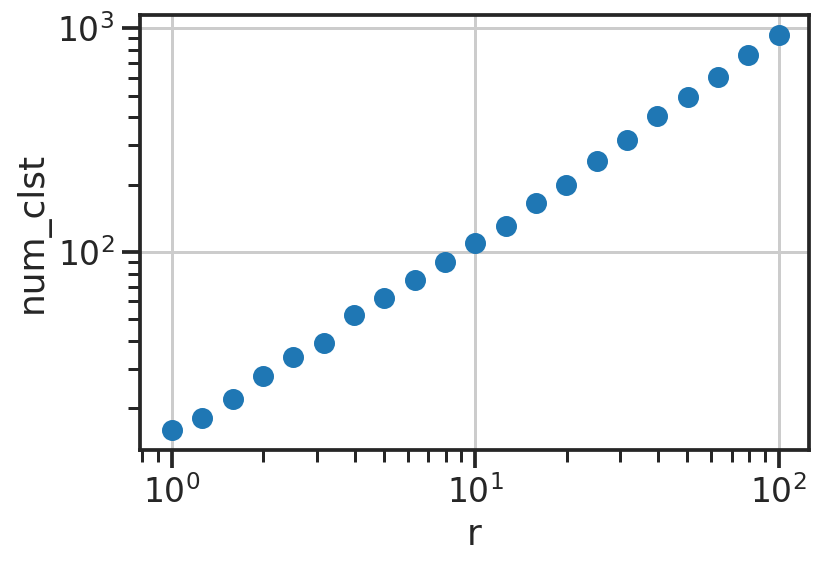

,r,num_clst
0,1.000000,16
1,1.258925,18
2,1.584893,22
3,1.995262,28
9,2.511886,34
11,3.162278,39
12,3.981072,52
15,5.011872,62
17,6.309573,75
19,7.943282,90


In [13]:
iterator_both = pd.merge(iterator_both, res_clsts)
print(iterator_both.shape)
iterator_both.head()

fig, ax = plt.subplots()
_x = iterator_both['r']
_y = iterator_both['num_clst']
ax.scatter(_x, _y)
ax.set_xlabel('r')
ax.set_ylabel('num_clst')
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

iterator_both[['r', 'num_clst']].sort_values('r')

# one analysis 

In [14]:
# choose 1 (r=100; num_clst=935) to proceed 
num_clst = 130
fname1, fname2, resolution = iterator_both[iterator_both['num_clst']==num_clst][['fname_mc', 'fname_atac', 'r']].iloc[0]

print(fname1)
print(fname2)

output_figures = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_{}_r{:.1f}_n{}_{{}}'.format(today, resolution, num_clst)
output_results = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/results_new/fig2_metacell_{}_r{:.1f}_n{}_{{}}'.format(today, resolution, num_clst)
print(output_figures)
print(output_results)



/cndd2/fangming/projects/scf_enhancers/results/mop_10x_cells_v3_snmcseq_gene_ka30_knn30_201206_0_cluster_r12.589254117941675_spearmanr_corrs.pkl
/cndd2/fangming/projects/scf_enhancers/results/mop_10x_cells_v3_snatac_gene_ka30_knn30_201206_0_cluster_r12.589254117941675_spearmanr_corrs.pkl
/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_201223_r12.6_n130_{}
/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/results_new/fig2_metacell_201223_r12.6_n130_{}


In [15]:
## organize data; get results
# get corrs
with open(fname1, 'rb') as fh:
    to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
res_corrs = to_evals[to_correlate].copy()
res_corrs['corr'] = corrs 
res_corrs['corr_shuff'] = corrs_shuffled
res_corrs['corr_shuff_cells'] = corrs_shuffled_cells

print(res_corrs.shape)
res_corrs.head()

(2340530, 7)


,gene,enh,dist,is_in_genebody,corr,corr_shuff,corr_shuff_cells
0,ENSMUSG00000000001,147520,995118,False,-0.041996,-0.009901,-0.166199
1,ENSMUSG00000000001,147522,985740,False,0.107584,0.430143,-0.111996
2,ENSMUSG00000000001,147523,983725,False,-0.012951,0.364299,-0.191632
3,ENSMUSG00000000001,147527,970444,False,-0.190704,0.215306,-0.146581
4,ENSMUSG00000000001,147528,969372,False,-0.214602,0.156645,-0.220239


In [16]:
with open(fname2, 'rb') as fh:
    to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
res2_corrs = to_evals[to_correlate].copy()
res2_corrs['corr'] = corrs 
res2_corrs['corr_shuff'] = corrs_shuffled
res2_corrs['corr_shuff_cells'] = corrs_shuffled_cells

print(res_corrs.shape)
res_corrs.head()

(2340530, 7)


,gene,enh,dist,is_in_genebody,corr,corr_shuff,corr_shuff_cells
0,ENSMUSG00000000001,147520,995118,False,-0.041996,-0.009901,-0.166199
1,ENSMUSG00000000001,147522,985740,False,0.107584,0.430143,-0.111996
2,ENSMUSG00000000001,147523,983725,False,-0.012951,0.364299,-0.191632
3,ENSMUSG00000000001,147527,970444,False,-0.190704,0.215306,-0.146581
4,ENSMUSG00000000001,147528,969372,False,-0.214602,0.156645,-0.220239


In [17]:
# mean pattern
n = 100
_dists = np.linspace(2*KB, 1000*KB, n)
res_corrs_median = res_corrs.groupby(pd.cut(res_corrs['dist'], _dists)).agg([np.median, 
                                                                             np.mean, 
                                                                             p25,
                                                                             p75,
                                                                            ])
res2_corrs_median = res2_corrs.groupby(pd.cut(res2_corrs['dist'], _dists)).agg([np.median, 
                                                                             np.mean, 
                                                                             p25,
                                                                             p75,
                                                                            ])

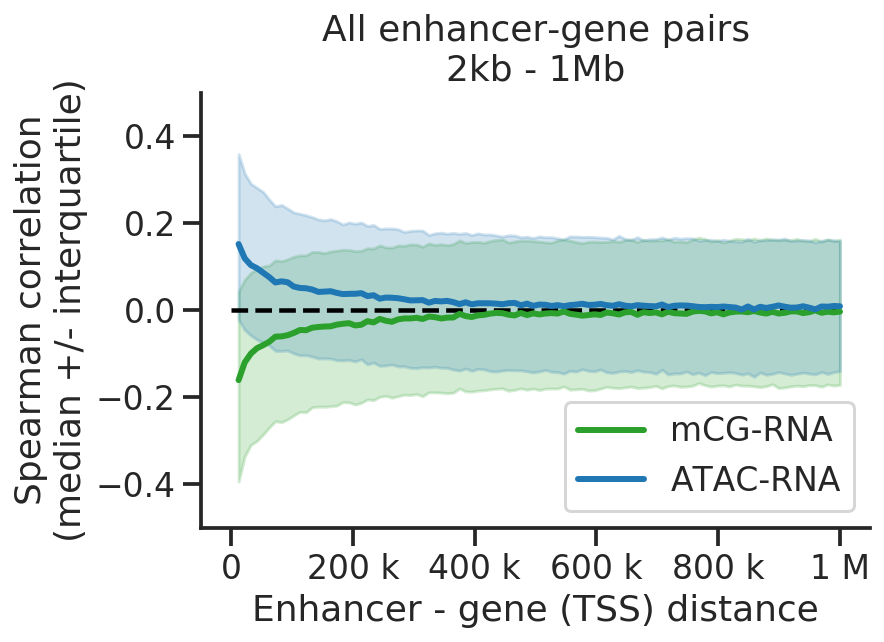

In [18]:
fig, ax = plt.subplots(figsize=(6,4))

_x = _dists[1:]
ax.hlines(0, 0, np.max(_x), linestyle='--')

_y = res_corrs_median['corr']['median'].values
_ylow = res_corrs_median['corr']['p25'].values
_yhigh = res_corrs_median['corr']['p75'].values
ax.plot(_x, _y, 
        label='mCG-RNA',
        linewidth=3,
        color=mod_palette['mc'])
ax.fill_between(_x, _ylow, _yhigh, color=mod_palette['mc'], alpha=0.2, 
#                 label='mCG interquartile',
               )
sns.despine(ax=ax)

_y = res2_corrs_median['corr']['median'].values
_ylow = res2_corrs_median['corr']['p25'].values
_yhigh = res2_corrs_median['corr']['p75'].values
ax.plot(_x, _y, 
        label='ATAC-RNA',
        linewidth=3,
        color=mod_palette['atac'])
ax.fill_between(_x, _ylow, _yhigh, color=mod_palette['atac'], alpha=0.2, 
#                 label='ATAC interquartile',
               )
sns.despine(ax=ax)
ax.grid(False)

ax.set_title('All enhancer-gene pairs\n2kb - 1Mb')
ax.set_ylabel('Spearman correlation\n(median +/- interquartile)')
ax.set_xlabel('Enhancer - gene (TSS) distance')
# ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.legend(bbox_to_anchor=(1,0), loc='lower right')
ax.xaxis.set_major_formatter(mtick.EngFormatter())
ax.set_ylim([-0.5, 0.5])

fig.savefig(output_figures.format('line_corr_dist.pdf'), bbox_inches='tight')
plt.show()

### Statistical evaluation 
first way: test on the right side

In [49]:
fdr = 0.2
dist_th = 1e5 # 100kb
# pval_type_shuffled, pval_type_shuffled_cells = 'left', 'both'
pval_type_shuffled, pval_type_shuffled_cells = 'right', 'both'
nbins = 501

res_stats = enhancer_gene_utils.get_significance_stats(
                            res_corrs[['gene', 'enh', 'dist']],
                            res_corrs['corr'],
                            res_corrs['corr_shuff'],
                            res_corrs['corr_shuff_cells'],
                            pval_type_shuffled, pval_type_shuffled_cells,
                            bins=np.linspace(-1,1,nbins),
                            distance_threshold=dist_th,
                            fdr_threshold=fdr,
                            positive_side=False,
                            return_pval=True,
                            return_cdf=False,
                        )
res2_stats = enhancer_gene_utils.get_significance_stats(
                            res2_corrs[['gene', 'enh', 'dist']],
                            res2_corrs['corr'],
                            res2_corrs['corr_shuff'],
                            res2_corrs['corr_shuff_cells'],
                            pval_type_shuffled, pval_type_shuffled_cells,
                            bins=np.linspace(-1,1,nbins),
                            distance_threshold=dist_th,
                            fdr_threshold=fdr,
                            positive_side=True,
                            return_pval=True,
                            return_cdf=False,
                        )
print(list(res_stats.keys()))
print(list(res2_stats.keys()))

failed to detect r_threshold:
['dist_th', 'num_total_pairs', 'num_total_genes', 'num_total_enhs', 'r_th_linked', 'r_th_linked_left', 'r_th_linked_right', 'r_th_correlated_left', 'r_th_correlated_right', 'num_linked_pairs', 'num_linked_genes', 'num_linked_enhs', 'linked_table', 'num_correlated_pairs', 'num_correlated_genes', 'num_correlated_enhs', 'correlated_table', 'bins', 'linked_pval', 'correlated_pval']
['dist_th', 'num_total_pairs', 'num_total_genes', 'num_total_enhs', 'r_th_linked', 'r_th_linked_left', 'r_th_linked_right', 'r_th_correlated_left', 'r_th_correlated_right', 'num_linked_pairs', 'num_linked_genes', 'num_linked_enhs', 'linked_table', 'num_correlated_pairs', 'num_correlated_genes', 'num_correlated_enhs', 'correlated_table', 'bins', 'linked_pval', 'correlated_pval']


In [50]:
# # save some results
# output = output_results.format('corr_results.pkl')
# print(output)

# with open(output, 'wb') as fh:
#     pickle.dump((to_evals, 
#                  res_corrs, res2_corrs, 
#                  res_stats, res2_stats,
#                 ), fh)

# save some results
output = output_results.format('linked_pairs_mc.tsv')
print(output)
res_stats['linked_table'].to_csv(output, sep="\t", header=True, index=False)
output = output_results.format('linked_pairs_atac.tsv')
res2_stats['linked_table'].to_csv(output, sep="\t", header=True, index=False)

output = output_results.format('correlated_pairs_mc.tsv')
print(output)
res_stats['correlated_table'].to_csv(output, sep="\t", header=True, index=False)
output = output_results.format('correlated_pairs_atac.tsv')
res2_stats['correlated_table'].to_csv(output, sep="\t", header=True, index=False)

/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/results_new/fig2_metacell_201223_r12.6_n130_linked_pairs_mc.tsv
/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/results_new/fig2_metacell_201223_r12.6_n130_correlated_pairs_mc.tsv


In [53]:
print(len(res_stats['linked_table']), len(res2_stats['linked_table']))
print(res_stats['r_th_linked'], res2_stats['r_th_linked'])

0 0
0.9082484100798142 nan


### Statistical evaluation 2 

second way: reverse corr

In [57]:
fdr = 0.2
dist_th = 1e5 # 100kb
# pval_type_shuffled, pval_type_shuffled_cells = 'left', 'both'
pval_type_shuffled, pval_type_shuffled_cells = 'left', 'both'
nbins = 501

res_stats = enhancer_gene_utils.get_significance_stats(
                            res_corrs[['gene', 'enh', 'dist']],
                            -res_corrs['corr'],
                            -res_corrs['corr_shuff'],
                            -res_corrs['corr_shuff_cells'],
                            pval_type_shuffled, pval_type_shuffled_cells,
                            bins=np.linspace(-1,1,nbins),
                            distance_threshold=dist_th,
                            fdr_threshold=fdr,
                            positive_side=False,
                            return_pval=True,
                            return_cdf=False,
                        )
res2_stats = enhancer_gene_utils.get_significance_stats(
                            res2_corrs[['gene', 'enh', 'dist']],
                            -res2_corrs['corr'],
                            -res2_corrs['corr_shuff'],
                            -res2_corrs['corr_shuff_cells'],
                            pval_type_shuffled, pval_type_shuffled_cells,
                            bins=np.linspace(-1,1,nbins),
                            distance_threshold=dist_th,
                            fdr_threshold=fdr,
                            positive_side=True,
                            return_pval=True,
                            return_cdf=False,
                        )
print(list(res_stats.keys()))
print(list(res2_stats.keys()))

failed to detect r_threshold:
['dist_th', 'num_total_pairs', 'num_total_genes', 'num_total_enhs', 'r_th_linked', 'r_th_linked_left', 'r_th_linked_right', 'r_th_correlated_left', 'r_th_correlated_right', 'num_linked_pairs', 'num_linked_genes', 'num_linked_enhs', 'linked_table', 'num_correlated_pairs', 'num_correlated_genes', 'num_correlated_enhs', 'correlated_table', 'bins', 'linked_pval', 'correlated_pval']
['dist_th', 'num_total_pairs', 'num_total_genes', 'num_total_enhs', 'r_th_linked', 'r_th_linked_left', 'r_th_linked_right', 'r_th_correlated_left', 'r_th_correlated_right', 'num_linked_pairs', 'num_linked_genes', 'num_linked_enhs', 'linked_table', 'num_correlated_pairs', 'num_correlated_genes', 'num_correlated_enhs', 'correlated_table', 'bins', 'linked_pval', 'correlated_pval']


In [58]:
# # save some results
# output = output_results.format('corr_results.pkl')
# print(output)

# with open(output, 'wb') as fh:
#     pickle.dump((to_evals, 
#                  res_corrs, res2_corrs, 
#                  res_stats, res2_stats,
#                 ), fh)

# save some results
output = output_results.format('linked_pairs_mc.tsv')
print(output)
res_stats['linked_table'].to_csv(output, sep="\t", header=True, index=False)
output = output_results.format('linked_pairs_atac.tsv')
res2_stats['linked_table'].to_csv(output, sep="\t", header=True, index=False)

output = output_results.format('correlated_pairs_mc.tsv')
print(output)
res_stats['correlated_table'].to_csv(output, sep="\t", header=True, index=False)
output = output_results.format('correlated_pairs_atac.tsv')
res2_stats['correlated_table'].to_csv(output, sep="\t", header=True, index=False)

/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/results_new/fig2_metacell_201223_r12.6_n130_linked_pairs_mc.tsv
/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/results_new/fig2_metacell_201223_r12.6_n130_correlated_pairs_mc.tsv


In [59]:
print(len(res_stats['linked_table']), len(res2_stats['linked_table']))
print(res_stats['r_th_linked'], res2_stats['r_th_linked'])

0 0
-0.9082484100759513 nan


# Venn diagrams
- compare different sets: mC, ATAC, CICERO
- linked, correlated

In [21]:
from matplotlib_venn import venn2
from matplotlib_venn import venn3

def venn_ax(ax, title, sets, set_labels, set_colors, 
            intformat=True,
             **kwargs):
    """
    venn2 or venn3
    kwargs include: normalize_to
    """
    if len(sets) == 3:
        out = venn3(sets,
                    set_labels=set_labels,
                    set_colors=set_colors,
                    ax=ax,
                    **kwargs,
                   )
    elif len(sets) == 2:
        out = venn2(sets,
                    set_labels=set_labels,
                    set_colors=set_colors,
                    ax=ax,
                    **kwargs,
                   )
    ax.set_title(title)
    
    if intformat:
        for text in out.subset_labels:
            text.set_text("{:,}".format(int(text.get_text())))
            text.set_fontsize(10)
    return out

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:57: UserWarning: Circle B has zero area
  warnings.warn("Circle B has zero area")
/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


AttributeError: 'NoneType' object has no attribute 'set_text'

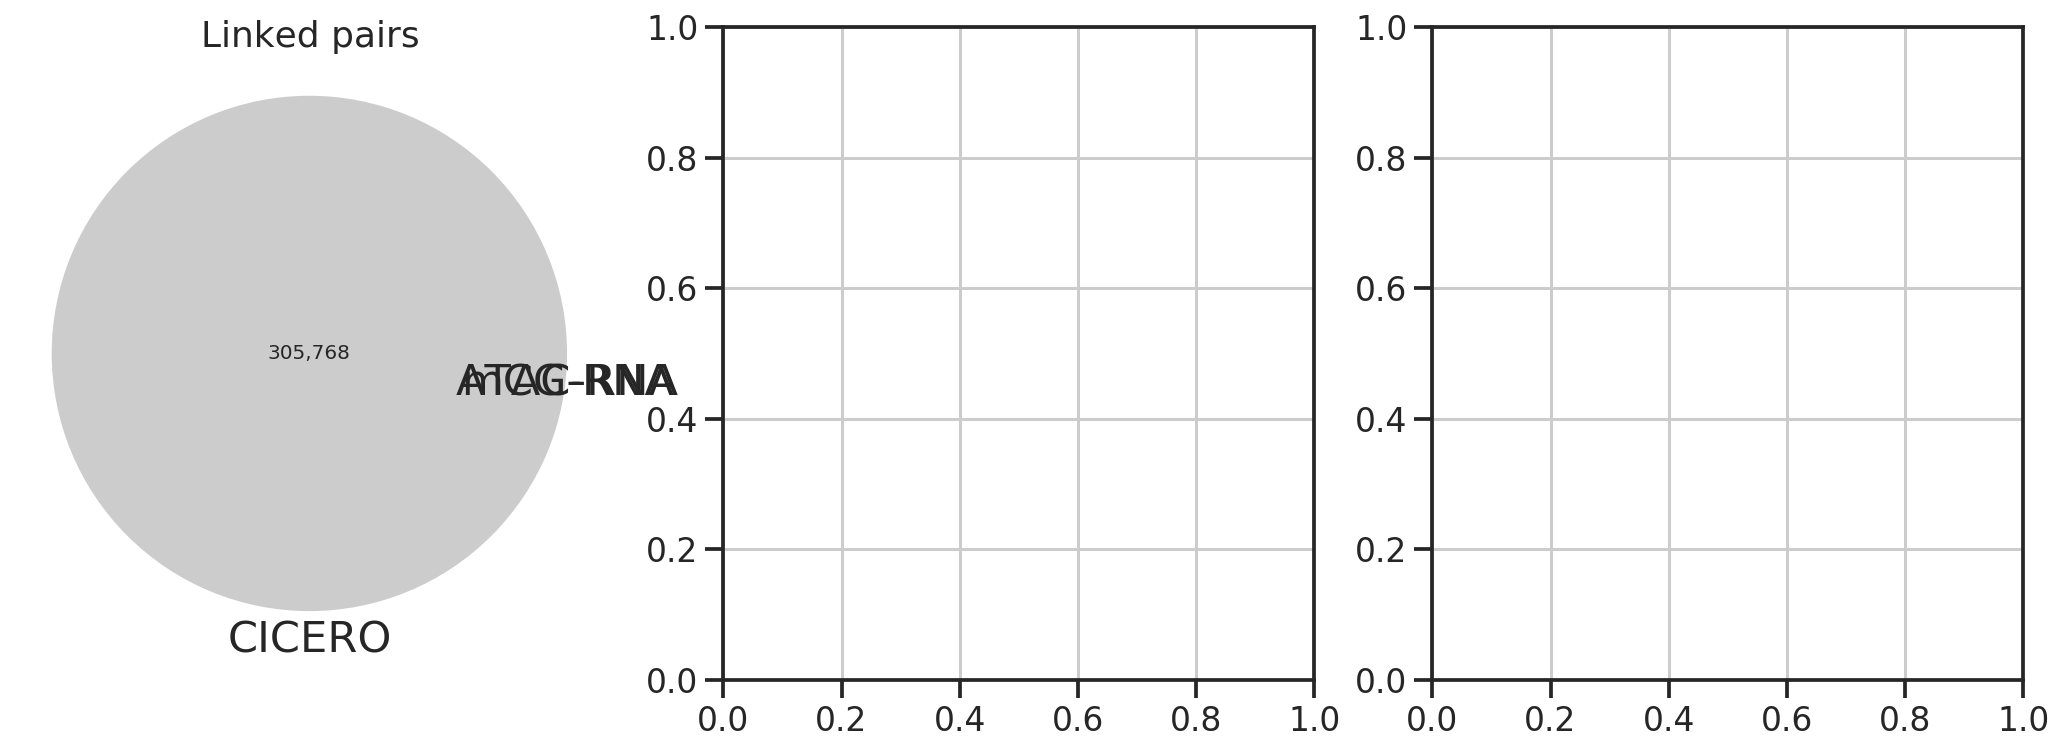

In [22]:
output = output_figures.format('venn_pairs_linked_cicero.pdf')

sets = [
    [
        set(enh_gene_links_cicero.index.values),
        set(res2_stats['linked_table'].index.values),
        set(res_stats['linked_table'].index.values), 
    ],
    [
        set(enh_gene_links_cicero['gene'].values),
        set(res2_stats['linked_table']['gene'].values),
        set(res_stats['linked_table']['gene'].values), 
    ],
    [
        set(enh_gene_links_cicero['enh'].values),
        set(res2_stats['linked_table']['enh'].values),
        set(res_stats['linked_table']['enh'].values),
    ],
]
sets_titles = ['Linked pairs', 'Linked genes overlap', 'Linked enhancers overlap']
set_labels=['CICERO', 'ATAC-RNA', 'mCG-RNA']
set_colors=['gray', mod_palette['atac'], mod_palette['mc']]

fig, axs = plt.subplots(1, 3, figsize=(3*6, 1*6))
for i, (ax, title) in enumerate(zip(
    axs, sets_titles)):
    
    out = venn_ax(ax, title, sets[i], set_labels, set_colors,
                 normalize_to=1.5,
                 )
    
#     true_area = len(sets[i][0]|sets[i][1]|sets[i][2])
#     ref_area = len(sets[0][0]|sets[0][1]|sets[0][2])
#     enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)

fig.subplots_adjust(wspace=0)
print(output)
snmcseq_utils.savefig(fig, output)

/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_201223_r12.6_n130_venn_pairs_correlated_cicero.pdf


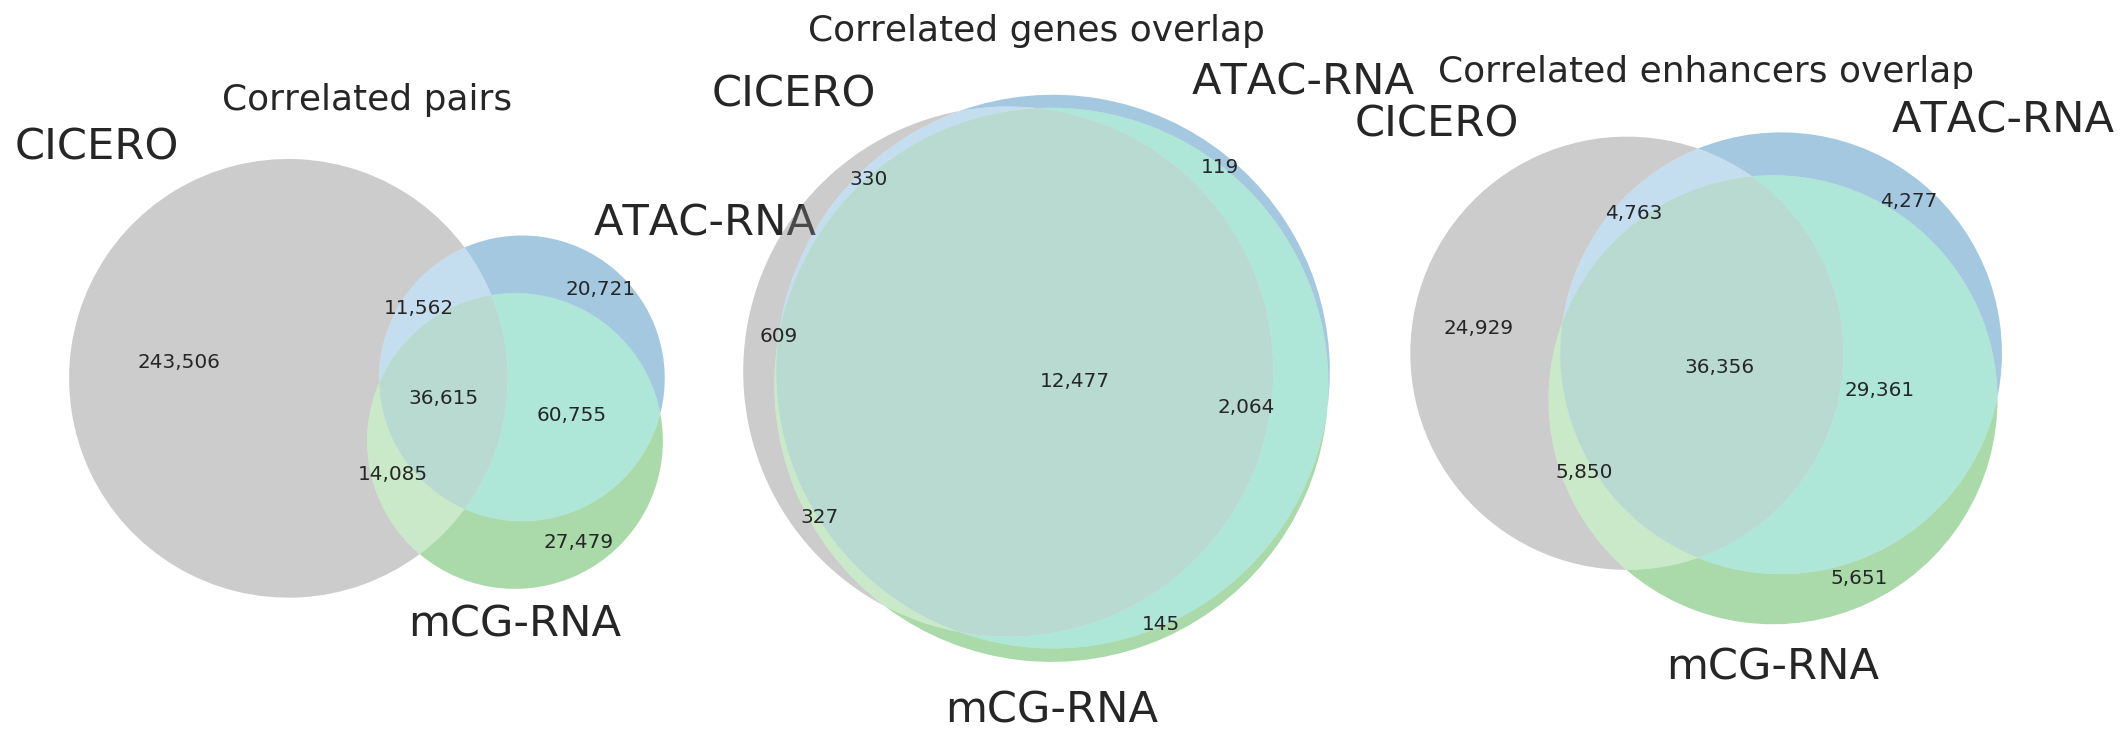

In [23]:
output = output_figures.format('venn_pairs_correlated_cicero.pdf')

sets = [
    [
        set(enh_gene_links_cicero.index.values),
        set(res2_stats['correlated_table'].index.values),
        set(res_stats['correlated_table'].index.values), 
    ],
    [
        set(enh_gene_links_cicero['gene'].values),
        set(res2_stats['correlated_table']['gene'].values),
        set(res_stats['correlated_table']['gene'].values), 
    ],
    [
        set(enh_gene_links_cicero['enh'].values),
        set(res2_stats['correlated_table']['enh'].values),
        set(res_stats['correlated_table']['enh'].values),
    ],
]

sets_titles = ['Correlated pairs', 'Correlated genes overlap', 'Correlated enhancers overlap']
set_labels=['CICERO', 'ATAC-RNA', 'mCG-RNA']
set_colors=['gray', mod_palette['atac'], mod_palette['mc']]

fig, axs = plt.subplots(1, 3, figsize=(3*6, 1*6))
for i, (ax, title) in enumerate(zip(
    axs, sets_titles)):
    
    venn_ax(ax, title, sets[i], set_labels, set_colors,
             normalize_to=1.5,
             )
#     true_area = len(sets[i][0]|sets[i][1]|sets[i][2])
#     ref_area = len(sets[0][0]|sets[0][1]|sets[0][2])
#     enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)

fig.subplots_adjust(wspace=0)
print(output)
snmcseq_utils.savefig(fig, output)

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib_venn/_venn2.py:50: UserWarning: Both circles have zero area
  warnings.warn("Both circles have zero area")


AttributeError: 'NoneType' object has no attribute 'set_text'

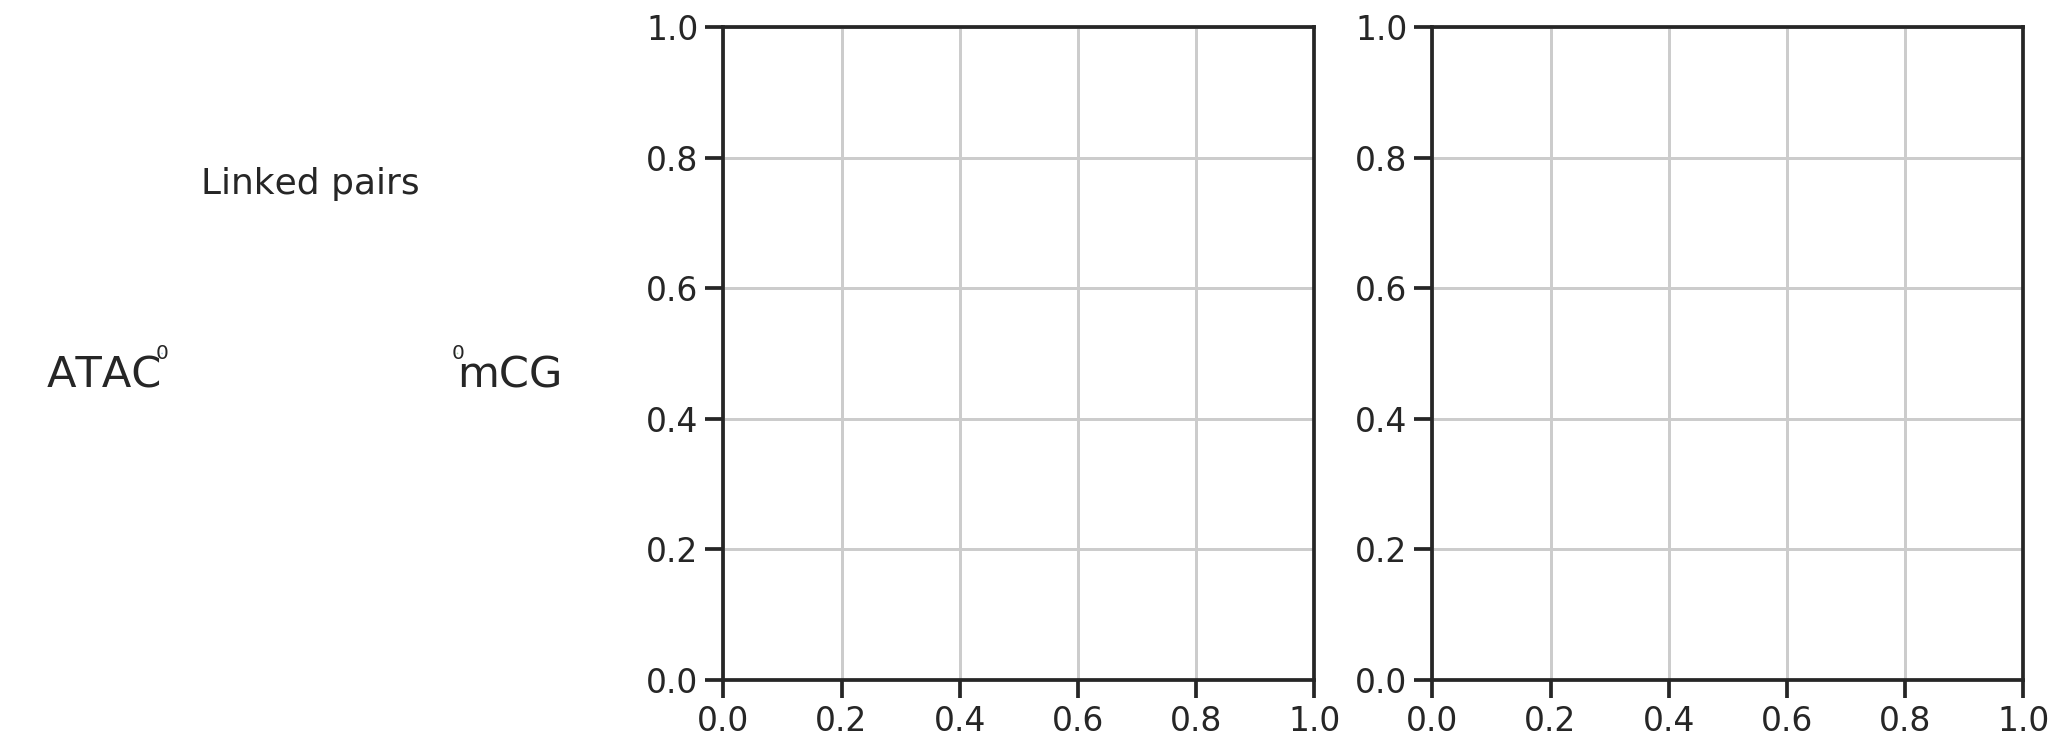

In [24]:
output = output_figures.format('ven_pairs_linked.pdf')

sets = [
    [set(res2_stats['linked_table'].index.values),
     set(res_stats['linked_table'].index.values)],
    [set(res2_stats['linked_table']['gene'].values),
     set(res_stats['linked_table']['gene'].values)],
    [set(res2_stats['linked_table']['enh'].values),
     set(res_stats['linked_table']['enh'].values)],
]

sets_titles = ['Linked pairs', 'Linked genes overlap', 'Linked enhancers overlap']
set_labels = ['ATAC', 'mCG']
set_colors = [mod_palette['atac'], mod_palette['mc']]

fig, axs = plt.subplots(1, 3, figsize=(3*6, 1*6))
for i, (ax, title) in enumerate(zip(
    axs, sets_titles)):
    
    venn_ax(ax, title, sets[i], set_labels, set_colors,
             normalize_to=1.5,
             )
    
    true_area = len(sets[i][0]|sets[i][1])
    ref_area = len(sets[0][0]|sets[0][1])
    enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)
    
fig.subplots_adjust(wspace=0)
print(output)
snmcseq_utils.savefig(fig, output)

/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_201223_r12.6_n130_ven_pairs_correlated.pdf


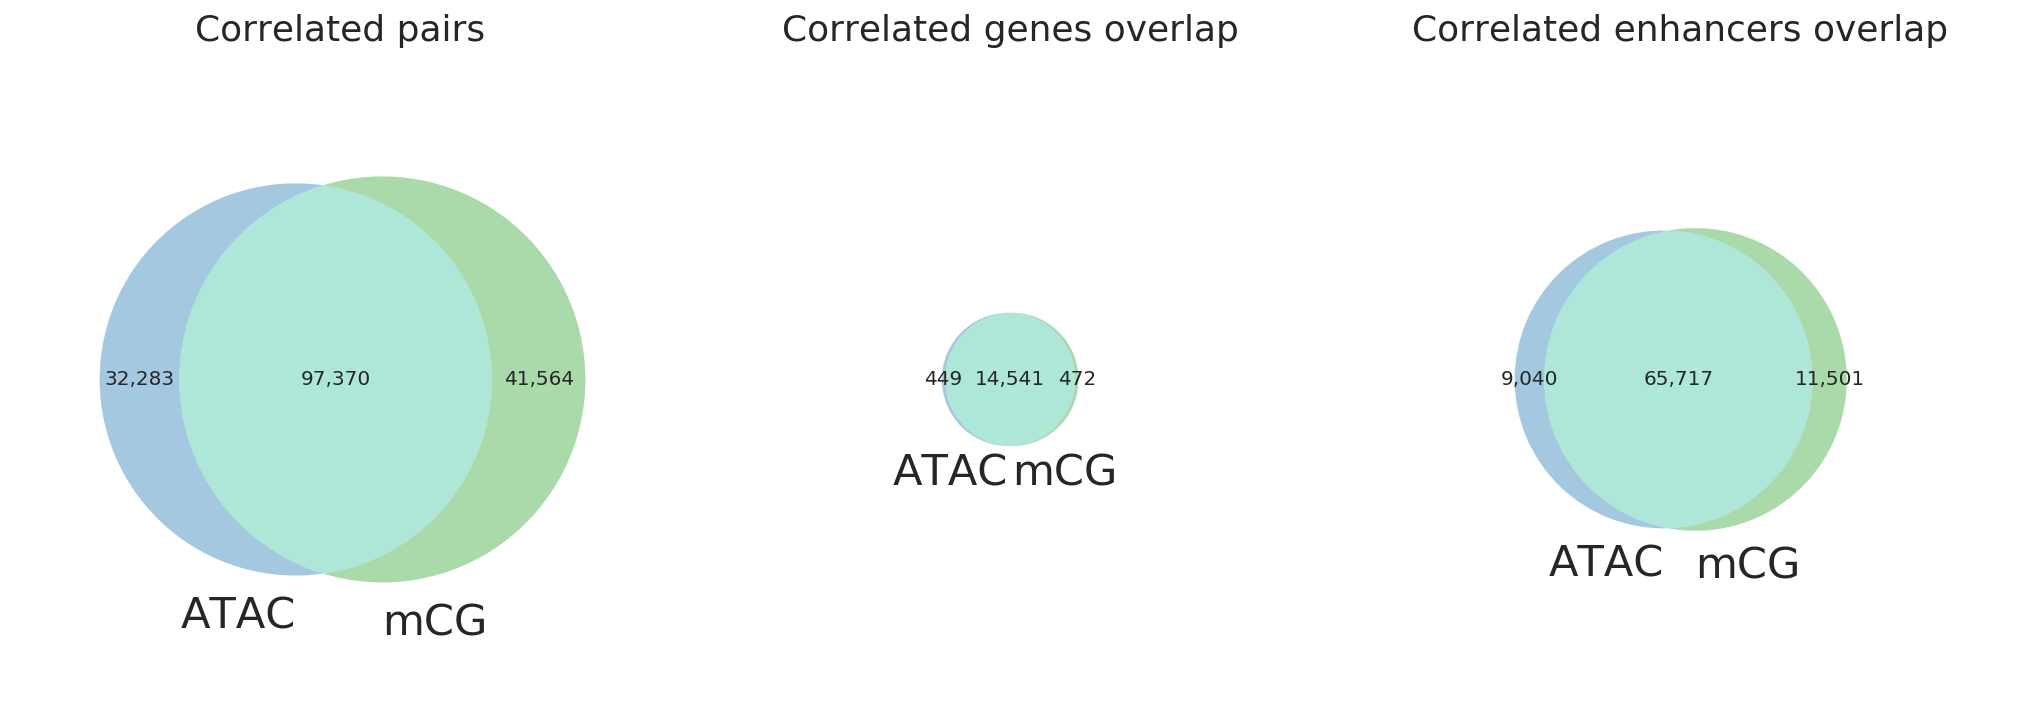

In [25]:
output = output_figures.format('ven_pairs_correlated.pdf')

sets = [
    [set(res2_stats['correlated_table'].index.values),
     set(res_stats['correlated_table'].index.values)],
    [set(res2_stats['correlated_table']['gene'].values),
     set(res_stats['correlated_table']['gene'].values)],
    [set(res2_stats['correlated_table']['enh'].values),
     set(res_stats['correlated_table']['enh'].values)],
]

sets_titles = ['Correlated pairs', 'Correlated genes overlap', 'Correlated enhancers overlap']
set_labels = ['ATAC', 'mCG']
set_colors = [mod_palette['atac'], mod_palette['mc']]

fig, axs = plt.subplots(1, 3, figsize=(3*6, 1*6))
for i, (ax, title) in enumerate(zip(
    axs, sets_titles)):
    
    venn_ax(ax, title, sets[i], set_labels, set_colors,
             normalize_to=1.5,
             )
    
    true_area = len(sets[i][0]|sets[i][1])
    ref_area = len(sets[0][0]|sets[0][1])
    enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)
    
fig.subplots_adjust(wspace=0)
print(output)
snmcseq_utils.savefig(fig, output)

AttributeError: 'NoneType' object has no attribute 'set_text'

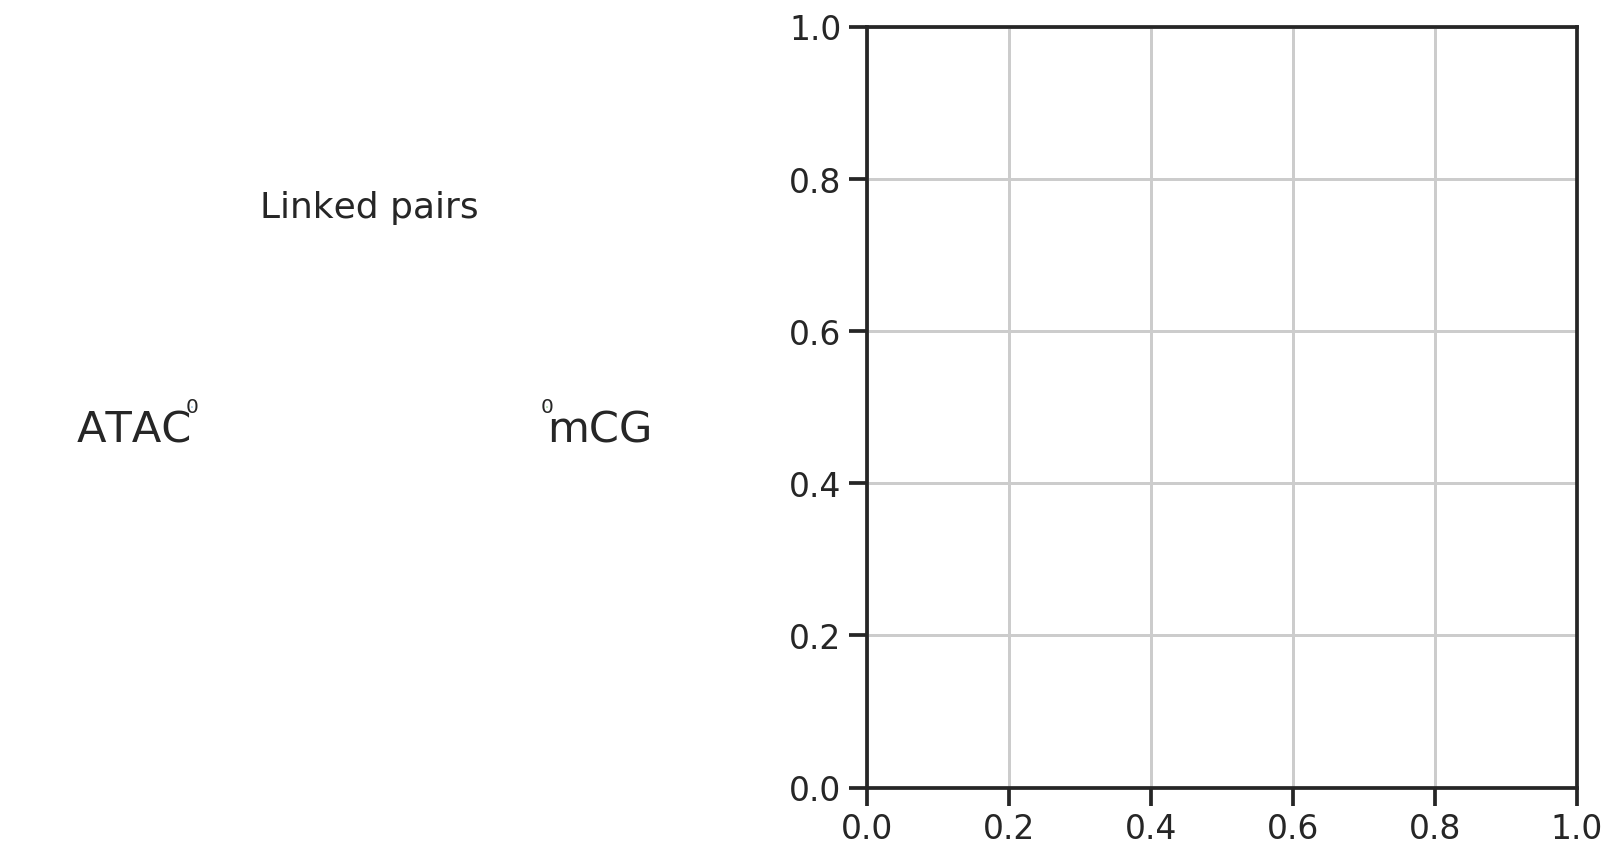

In [26]:
output = output_figures.format('ven_pairs_linkedvscorrelated.pdf')

sets = [
    [set(res2_stats['linked_table'].index.values),
     set(res_stats['linked_table'].index.values)],
    [set(res2_stats['correlated_table'].index.values),
     set(res_stats['correlated_table'].index.values)],
]

sets_titles = ['Linked pairs', 'Correlated pairs',]
set_labels = ['ATAC', 'mCG']
set_colors = [mod_palette['atac'], mod_palette['mc']]

fig, axs = plt.subplots(1, 2, figsize=(2*7, 1*7))
for i, (ax, title) in enumerate(zip(
    axs, sets_titles)):
    
    venn_ax(ax, title, sets[i], set_labels, set_colors,
            normalize_to=1.5,
            )
    
    true_area = len(sets[i][0]|sets[i][1])
    ref_area = len(sets[1][0]|sets[1][1])
    enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)
    
fig.subplots_adjust(wspace=0)
print(output)
snmcseq_utils.savefig(fig, output)

# Bar plots
- compare different sets

In [27]:
# annotate pairs
def yes_no_na(pair, pos_set, scope_set):
    """3 states = yes, no, NA = (1, 0, -1)
    """
#     assert pos_set.issubset(all_set)
    
    if pair not in scope_set:
        return -1
    return int(pair in pos_set)

# grand scope
sets = [
    set(res2_stats['linked_table'].index.values),
    set(res_stats['linked_table'].index.values),
    set(res2_stats['correlated_table'].index.values),
    set(res_stats['correlated_table'].index.values),
]
grand_scope = sets[0] | sets[1] | sets[2] | sets[3]

# correlated pos vs neg
# one track is one column
_tmp = pd.merge(res_stats['correlated_table'].reset_index(), 
                res_corrs, on=['gene', 'enh', 'dist'],
                how='left',
               )
_tmp2 = pd.merge(res2_stats['correlated_table'].reset_index(), 
                 res2_corrs, on=['gene', 'enh', 'dist'],
                 how='left',
                )

# get is_in_genebody, is_nearest_gene, is_cicero info
df_nngene = res_stats['linked_table'].copy().reset_index()
df_nngene['mod'] = 'mc'
# add is_in_genebody
df_nngene = pd.merge(df_nngene, 
                     to_evals[['gene', 'enh', 'is_in_genebody']], 
                     on=['gene', 'enh'],
                     how='left')
# add is_nearest_gene
df_nngene['nearest_gene'] = (enh_list_expand.set_index('index')
                                            .reindex(df_nngene['enh'].values.astype(int))
                                            ['gene_id']
                                            .apply(strip_gid_suffix)
                                            .values
                            )
df_nngene['is_nearest_gene'] = (df_nngene['gene'] == df_nngene['nearest_gene'])
# add is_cicero
df_nngene = pd.merge(df_nngene, enh_gene_links_cicero.reset_index().rename(columns={'index': 'is_cicero'}), 
                     on=['gene', 'enh'], 
                     how='left',
                    )
df_nngene['is_cicero'] = ~np.isnan(df_nngene['is_cicero'])
# summary
n_linked = len(df_nngene)
n_nngene = df_nngene['is_nearest_gene'].sum()
print("{}/{}={:.2f} pairs are from the nearest genes"
      .format(n_nngene, n_linked, n_nngene/n_linked))

# get is_in_genebody, is_nearest_gene, is_cicero info
df2_nngene = res2_stats['linked_table'].copy().reset_index()
df2_nngene['mod'] = 'atac'
# add is_in_genebody
df2_nngene = pd.merge(df2_nngene, 
                      to_evals[['gene', 'enh', 'is_in_genebody']], 
                      on=['gene', 'enh'],
                      how='left')
# add is_nearest_gene
df2_nngene['nearest_gene'] = (enh_list_expand.set_index('index')
                                             .reindex(df2_nngene['enh'].values.astype(int))
                                             ['gene_id']
                                             .apply(strip_gid_suffix)
                                             .values
                            )
df2_nngene['is_nearest_gene'] = (df2_nngene['gene'] == df2_nngene['nearest_gene'])
# add is_cicero
df2_nngene = pd.merge(df2_nngene, enh_gene_links_cicero.reset_index().rename(columns={'index': 'is_cicero'}), 
                     on=['gene', 'enh'], 
                     how='left',
                    )
df2_nngene['is_cicero'] = ~np.isnan(df2_nngene['is_cicero'])
# summary
n_linked = len(df2_nngene)
n_nngene = df2_nngene['is_nearest_gene'].sum()
print("{}/{}={:.2f} pairs are from the nearest genes"
      .format(n_nngene, n_linked, n_nngene/n_linked))


# pairs_annot
pairs_annot = pd.DataFrame(index=grand_scope)

pairs_annot['ATAC_linked'] = [yes_no_na(pair, sets[0], grand_scope) for pair in pairs_annot.index]
pairs_annot['mCG_linked'] = [yes_no_na(pair, sets[1], grand_scope) for pair in pairs_annot.index]
pairs_annot['ATAC_correlated'] = [yes_no_na(pair, sets[2], grand_scope) for pair in pairs_annot.index]
pairs_annot['mCG_correlated'] = [yes_no_na(pair, sets[3], grand_scope) for pair in pairs_annot.index]

# among correlated mc
pos_set = set(_tmp[_tmp['corr']>0]['index'])
scope_set = set(_tmp['index'])
pairs_annot['correlated_mc_pos'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]
# among correlated atac
pos_set = set(_tmp2[_tmp2['corr']>0]['index'])
scope_set = set(_tmp2['index'])
pairs_annot['correlated_atac_pos'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]

# among linked mc
pos_set = set(df_nngene['index'])
scope_set = grand_scope
pairs_annot['linked_mc'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]

pos_set = set(df_nngene[df_nngene['is_in_genebody']]['index'])
scope_set = set(df_nngene['index'])
pairs_annot['linked_mc_is_in_genebody'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]

pos_set = set(df_nngene[df_nngene['is_nearest_gene']]['index'])
scope_set = set(df_nngene['index'])
pairs_annot['linked_mc_is_nearest_gene'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]

pos_set = set(df_nngene[df_nngene['is_cicero']]['index'])
scope_set = set(df_nngene['index'])
pairs_annot['linked_mc_is_cicero'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]

# among linked atac
pos_set = set(df2_nngene['index'])
scope_set = grand_scope
pairs_annot['linked_atac'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]

pos_set = set(df2_nngene[df2_nngene['is_in_genebody']]['index'])
scope_set = set(df2_nngene['index'])
pairs_annot['linked_atac_is_in_genebody'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]

pos_set = set(df2_nngene[df2_nngene['is_nearest_gene']]['index'])
scope_set = set(df2_nngene['index'])
pairs_annot['linked_atac_is_nearest_gene'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]

pos_set = set(df2_nngene[df2_nngene['is_cicero']]['index'])
scope_set = set(df2_nngene['index'])
pairs_annot['linked_atac_is_cicero'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]

print(pairs_annot.shape)
pairs_annot.head()

<ipython-input-27-107e7f8264e1>:57: RuntimeWarning: invalid value encountered in long_scalars
  .format(n_nngene, n_linked, n_nngene/n_linked))


0/0=nan pairs are from the nearest genes


<ipython-input-27-107e7f8264e1>:85: RuntimeWarning: invalid value encountered in long_scalars
  .format(n_nngene, n_linked, n_nngene/n_linked))


0/0=nan pairs are from the nearest genes
(171217, 14)


,ATAC_linked,mCG_linked,ATAC_correlated,mCG_correlated,correlated_mc_pos,correlated_atac_pos,linked_mc,linked_mc_is_in_genebody,linked_mc_is_nearest_gene,linked_mc_is_cicero,linked_atac,linked_atac_is_in_genebody,linked_atac_is_nearest_gene,linked_atac_is_cicero
2097157,0,0,1,0,-1,1,0,-1,-1,-1,0,-1,-1,-1
1048586,0,0,1,1,0,1,0,-1,-1,-1,0,-1,-1,-1
1048587,0,0,1,1,1,0,0,-1,-1,-1,0,-1,-1,-1
1048588,0,0,1,0,-1,1,0,-1,-1,-1,0,-1,-1,-1
1048591,0,0,1,1,0,1,0,-1,-1,-1,0,-1,-1,-1


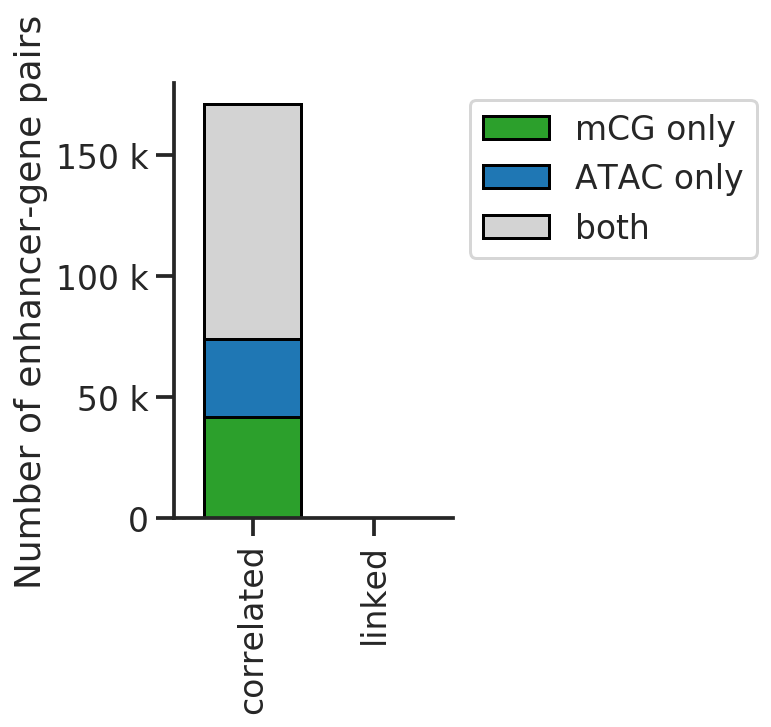

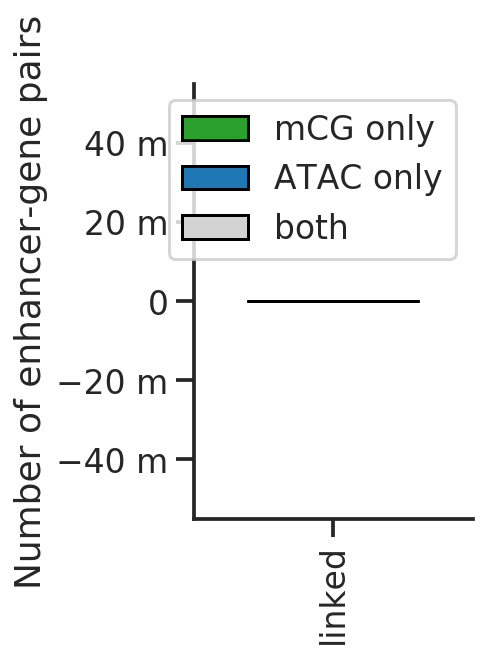

In [28]:
output1 = output_figures.format('bar_pairs_linkedvscorrelated.pdf')
output2 = output_figures.format('bar_pairs_linked.pdf')

df_col1 = pairs_annot.groupby(['ATAC_linked', 'mCG_linked']).size()
df_col1.index = df_col1.index.values
df_col2 = pairs_annot.groupby(['ATAC_correlated', 'mCG_correlated']).size()
df_col2.index = df_col2.index.values
df = pd.concat([df_col1, df_col2], axis=1).rename(columns={0:'linked', 1: 'correlated'}).fillna(0).astype(int)
df.index = df.index.values
rename_labels = {
    (0, 0): 'None',
    (0, 1): 'mCG only',
    (1, 0): 'ATAC only',
    (1, 1): 'both',
}
df = df.T.head().rename(columns=rename_labels)[['mCG only', 'ATAC only', 'both']].reindex(['correlated', 'linked'])
colors = [mod_palette['mc'], mod_palette['atac'], 'lightgray',]

with sns.axes_style({
                     'patch.edgecolor': 'k',
                     'grid.linestyle': '',
                    }):
    
    fig, ax = plt.subplots(figsize=(2.5,4))
    df.plot.bar(stacked=True, width=0.8, color=colors, ax=ax)
    
    sns.despine(ax=ax)
    ax.yaxis.set_major_formatter(mtick.EngFormatter())
    ax.set_ylabel('Number of enhancer-gene pairs')
    
    # legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1,1))
    
    snmcseq_utils.savefig(fig, output1)
    plt.show()
    
    
    fig, ax = plt.subplots(figsize=(2.5,4))
    df.loc[['linked']].plot.bar(stacked=True, width=0.8, color=colors, ax=ax)
    
    sns.despine(ax=ax)
    ax.yaxis.set_major_formatter(mtick.EngFormatter())
    ax.set_ylabel('Number of enhancer-gene pairs')
    
    # legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1,1))
    
    snmcseq_utils.savefig(fig, output2)
    plt.show()

/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_201223_r12.6_n130_bar_frac_pos_neg.pdf


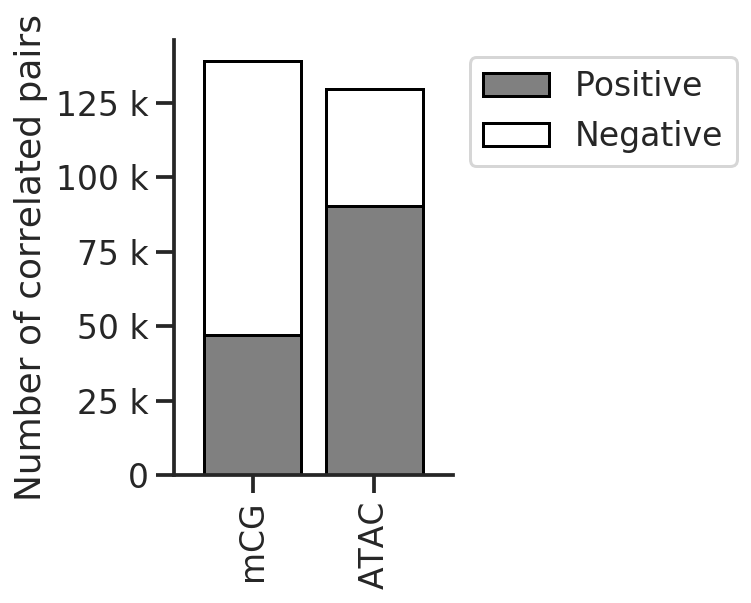

In [29]:
output = output_figures.format('bar_frac_pos_neg.pdf')

df = pd.concat([
        pairs_annot.groupby(['correlated_mc_pos']).size(),
        pairs_annot.groupby(['correlated_atac_pos']).size(),
    ], axis=1).rename(columns={
        0: 'mCG', 
        1: 'ATAC',
}).fillna(0).astype(int)

df = df.T.rename(columns={0:'Negative', 1: 'Positive', -1: 'NA'})[['Positive', 'Negative',]]
colors = ['gray', 'white']

with sns.axes_style({
                     'patch.edgecolor': 'k',
                     'grid.linestyle': '',
                    }):
    
    fig, ax = plt.subplots(figsize=(2.5,4))
    df.plot.bar(stacked=True, width=0.8, color=colors, ax=ax)
    
    sns.despine(ax=ax)
    ax.yaxis.set_major_formatter(mtick.EngFormatter())
    ax.set_ylabel('Number of correlated pairs')
    
    # legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1,1))
    print(output)
    snmcseq_utils.savefig(fig, output)
    
#     fig, ax = plt.subplots(figsize=(3,4))
#     df.divide(df.sum(axis=1), axis=0).plot.bar(stacked=True, width=0.6, color=colors, ax=ax)
#     sns.despine(ax=ax)
#     ax.yaxis.set_major_formatter(mtick.PercentFormatter())
#     ax.set_ylabel('Number of enhancer-gene pairs')
    
#     # legend
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles, labels, bbox_to_anchor=(1,1))
#     print(output)
#     snmcseq_utils.savefig(fig, output)

In [30]:
output = output_figures.format('bar_linked_decomp.pdf')

dfs = []
titles = [
    'Nearest genes?', 
    'In gene body?', 
    'In CICERO?', 
    ]

# nearest gene
df = pd.concat([
        pairs_annot.groupby(['linked_mc_is_nearest_gene']).size(),
        pairs_annot.groupby(['linked_atac_is_nearest_gene']).size(),
    ], axis=1).rename(columns={
        0: 'mCG', 
        1: 'ATAC',
}).fillna(0).astype(int)
df = df.T.rename(columns={0:'No', 1: 'Yes', -1: 'NA'})[['Yes', 'No']]
dfs.append(df)

# gene body
df = pd.concat([
        pairs_annot.groupby(['linked_mc_is_in_genebody']).size(),
        pairs_annot.groupby(['linked_atac_is_in_genebody']).size(),
    ], axis=1).rename(columns={
        0: 'mCG', 
        1: 'ATAC',
}).fillna(0).astype(int)
df = df.T.rename(columns={0:'No', 1: 'Yes', -1: 'NA'})[['Yes', 'No']]
dfs.append(df)

# CICERO
df = pd.concat([
        pairs_annot.groupby(['linked_mc_is_cicero']).size(),
        pairs_annot.groupby(['linked_atac_is_cicero']).size(),
    ], axis=1).rename(columns={
        0: 'mCG', 
        1: 'ATAC',
}).fillna(0).astype(int)
df = df.T.rename(columns={0:'No', 1: 'Yes', -1: 'NA'})[['Yes', 'No']]
dfs.append(df)

colors = ['gray', 'white']

with sns.axes_style({
                     'patch.edgecolor': 'k',
                     'grid.linestyle': '',
                    }):
    
    
    fig, axs = plt.subplots(1, 3, figsize=(2.5*3,4*1), sharey=True)
    
    for ax, df, title in zip(axs, dfs, titles):
        df.plot.bar(stacked=True, width=0.8, color=colors, ax=ax, legend=False)
        sns.despine(ax=ax)
        ax.yaxis.set_major_formatter(mtick.EngFormatter())
        ax.set_title(title)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        
    axs[0].set_ylabel('Number of linked pairs')
    # legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1,1))
    print(output)
    snmcseq_utils.savefig(fig, output)


KeyError: "None of [Index(['Yes', 'No'], dtype='object')] are in the [columns]"

In [31]:
output = output_figures.format('bar_linked_decomp_v2.pdf')

dfs = []
titles = [
    'Nearest genes?', 
    'In gene body?', 
    'In CICERO?', 
    ]


# nearest gene
df = pd.concat([
        pairs_annot[((pairs_annot['linked_mc']==1)&(pairs_annot['linked_atac']==0))]
                    .groupby(['linked_mc_is_nearest_gene']).size(),
        pairs_annot[((pairs_annot['linked_mc']==0)&(pairs_annot['linked_atac']==1))]
                    .groupby(['linked_atac_is_nearest_gene']).size(),
        pairs_annot[((pairs_annot['linked_mc']==1)&(pairs_annot['linked_atac']==1))]
                    .groupby(['linked_atac_is_nearest_gene']).size(),
    ], axis=1).rename(columns={
        0: 'mCG only', 
        1: 'ATAC only',
        2: 'both',
}).fillna(0).astype(int)
df = df.T.rename(columns={0:'No', 1: 'Yes', -1: 'NA'})[['Yes', 'No']]
dfs.append(df)

# gene body
df = pd.concat([
        pairs_annot[((pairs_annot['linked_mc']==1)&(pairs_annot['linked_atac']==0))]
                    .groupby(['linked_mc_is_in_genebody']).size(),
        pairs_annot[((pairs_annot['linked_mc']==0)&(pairs_annot['linked_atac']==1))]
                    .groupby(['linked_atac_is_in_genebody']).size(),
        pairs_annot[((pairs_annot['linked_mc']==1)&(pairs_annot['linked_atac']==1))]
                    .groupby(['linked_atac_is_in_genebody']).size(),
    ], axis=1).rename(columns={
        0: 'mCG only', 
        1: 'ATAC only',
        2: 'both',
}).fillna(0).astype(int)
df = df.T.rename(columns={0:'No', 1: 'Yes', -1: 'NA'})[['Yes', 'No']]
dfs.append(df)

# CICERO
df = pd.concat([
        pairs_annot[((pairs_annot['linked_mc']==1)&(pairs_annot['linked_atac']==0))]
                    .groupby(['linked_mc_is_cicero']).size(),
        pairs_annot[((pairs_annot['linked_mc']==0)&(pairs_annot['linked_atac']==1))]
                    .groupby(['linked_atac_is_cicero']).size(),
        pairs_annot[((pairs_annot['linked_mc']==1)&(pairs_annot['linked_atac']==1))]
                    .groupby(['linked_atac_is_cicero']).size(),
    ], axis=1).rename(columns={
        0: 'mCG only', 
        1: 'ATAC only',
        2: 'both',
}).fillna(0).astype(int)
df = df.T.rename(columns={0:'No', 1: 'Yes', -1: 'NA'})[['Yes', 'No']]
dfs.append(df)

colors = ['gray', 'white']

with sns.axes_style({
                     'patch.edgecolor': 'k',
                     'grid.linestyle': '',
                    }):
    
    fig, axs = plt.subplots(1, 3, figsize=(3*3,4*1), sharey=True)
    
    for ax, df, title in zip(axs, dfs, titles):
        df.plot.bar(stacked=True, width=0.8, color=colors, ax=ax, legend=False)
        sns.despine(ax=ax)
        ax.yaxis.set_major_formatter(mtick.EngFormatter())
        ax.set_title(title)
#         ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        
    axs[0].set_ylabel('Number of linked pairs')
    # legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1,1))
    print(output)
    snmcseq_utils.savefig(fig, output)


KeyError: "None of [Index(['Yes', 'No'], dtype='object')] are in the [columns]"

###  add venn diagram

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:47: UserWarning: All circles have zero area
  warnings.warn("All circles have zero area")


AttributeError: 'NoneType' object has no attribute 'set_text'

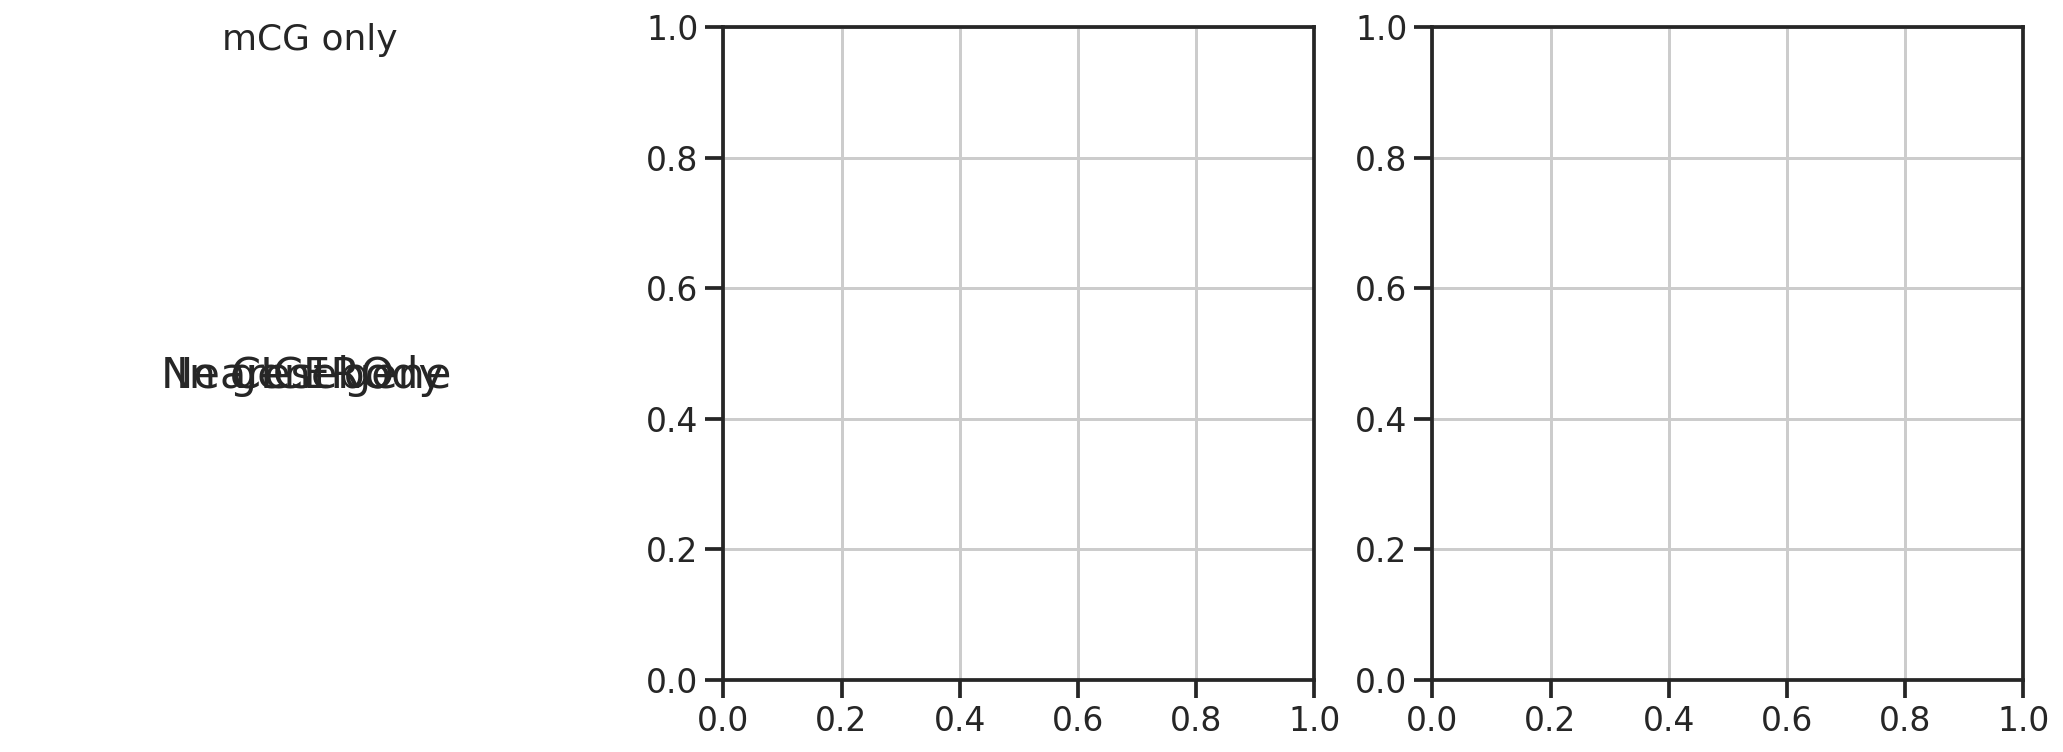

In [32]:
output = output_figures.format('venn_pairs_linked.pdf')

pairs_scope_mconly = pairs_annot[((pairs_annot['linked_mc']==1)&(pairs_annot['linked_atac']==0))]
pairs_scope_ataconly = pairs_annot[((pairs_annot['linked_mc']==0)&(pairs_annot['linked_atac']==1))]
pairs_scope_both = pairs_annot[((pairs_annot['linked_mc']==1)&(pairs_annot['linked_atac']==1))]

sets = [
    [
        set(pairs_scope_mconly[pairs_scope_mconly['linked_mc_is_nearest_gene']==1].index.values),
        set(pairs_scope_mconly[pairs_scope_mconly['linked_mc_is_in_genebody']==1].index.values),
        set(pairs_scope_mconly[pairs_scope_mconly['linked_mc_is_cicero']==1].index.values), 
    ],
    [
        set(pairs_scope_ataconly[pairs_scope_ataconly['linked_atac_is_nearest_gene']==1].index.values),
        set(pairs_scope_ataconly[pairs_scope_ataconly['linked_atac_is_in_genebody']==1].index.values),
        set(pairs_scope_ataconly[pairs_scope_ataconly['linked_atac_is_cicero']==1].index.values), 
    ],
    [
        set(pairs_scope_both[pairs_scope_both['linked_mc_is_nearest_gene']==1].index.values),
        set(pairs_scope_both[pairs_scope_both['linked_mc_is_in_genebody']==1].index.values),
        set(pairs_scope_both[pairs_scope_both['linked_mc_is_cicero']==1].index.values), 
    ],
]

sets_titles = ['mCG only', 'ATAC only', 'both']
set_labels=['Nearest gene', 'In genebody', 'CICERO']
set_colors=['C0', 'C1', 'C2']

fig, axs = plt.subplots(1, 3, figsize=(3*6, 1*6))
for i, (ax, title) in enumerate(zip(
    axs, sets_titles)):
    
    out = venn_ax(ax, title, sets[i], set_labels, set_colors,
                 normalize_to=1.5,
                 )
    for text in out.set_labels:
        text.set_fontsize(15)
        
    true_area = len(sets[i][0]|sets[i][1]|sets[i][2])
    ref_area = len(sets[0][0]|sets[0][1]|sets[0][2])
    enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)
    

fig.subplots_adjust(wspace=0)
print(output)
snmcseq_utils.savefig(fig, output)

### Estimate frac tps
- Num significant (use the other code)

In [33]:
def estimate_frac_tps(pvalues, bin_n=100, frac_bin_null=0.20):
    """Use the median of the last 5% (frac_bin_null) of bins to estimate null level
    """
    y = np.sort(pvalues)
    bin_edges = np.linspace(0, 1, bin_n)
    bin_width = 1.0/bin_n
    
    bin_counts, bin_edges = np.histogram(y, bin_edges)
    y_norm = bin_counts/(bin_width*bin_counts.sum())
    null_level = np.median(y_norm[-int(frac_bin_null*bin_n):])
    frac_tp = np.clip(1 - null_level, 0, 1)
    
    return frac_tp, null_level, bin_counts, bin_edges, y_norm
    
def plot_pval_dist(ax, frac_tp, null_level, bin_counts, bin_edges, y_norm, fillcolor='C0'):
    _x = bin_edges[:-1]
    ax.plot(_x, y_norm, color='k')
    ax.plot([0, 1], [null_level]*2, linestyle='--', color='k')
    ax.fill_between(_x, null_level, y_norm, 
                    where=y_norm>null_level, alpha=1, color=fillcolor)
    ax.fill_between(_x, 0, np.minimum(y_norm, null_level), alpha=0.5, color='lightgray')
    ax.text(0, null_level+0.2*(1-null_level), 
            "{:.1f}%".format(frac_tp*100), 
            color='white',
            fontsize=18)
    sns.despine(ax=ax)
    return ax

def pipe_plot_pval_dist(ax, pvalues, bin_n=100, frac_bin_null=0.20, fillcolor='C0'):
    """
    """
    # fit distribution 
    frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(pvalues, bin_n=bin_n, frac_bin_null=frac_bin_null)
    # plot it out 
    plot_pval_dist(ax, 
                   frac_tp, null_level, bin_counts, bin_edges, y_norm, 
                   fillcolor=fillcolor,
                  )
    return 
    

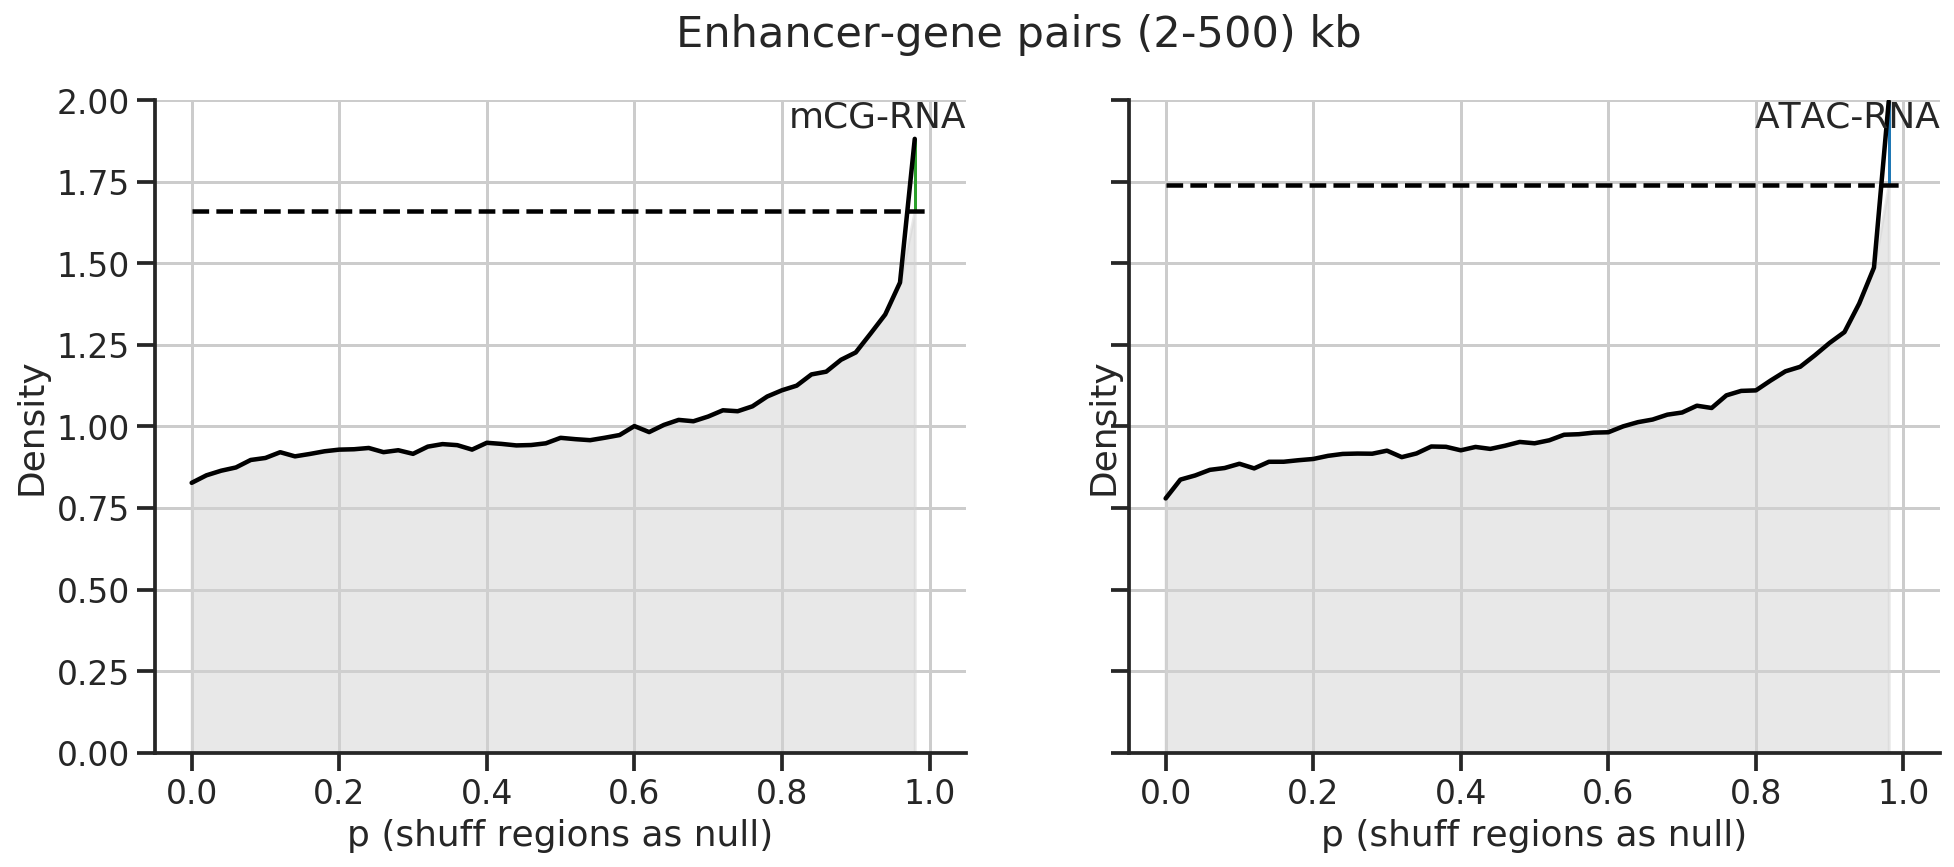

In [34]:
# plot pvalue distributions

ATAC_SIGN = -1
dist_th_this_plot = 5*1e5
bin_n = 51
frac_bin_null = 0.05

pvals = [
    np.interp(res_corrs[res_corrs['dist']<dist_th_this_plot]['corr'], res_stats['bins'][1:], res_stats['linked_pval']),
    np.interp(ATAC_SIGN*res2_corrs[res2_corrs['dist']<dist_th_this_plot]['corr'], res2_stats['bins'][1:], res2_stats['linked_pval']),
]
labels = ['mCG-RNA', 'ATAC-RNA']
colors = [mod_palette['mc'], mod_palette['atac']]

fig, axs = plt.subplots(1, 2, figsize=(8*2,6), sharex=True, sharey=True)
for ax, pval, label, color in zip(axs, pvals, labels, colors):
    pipe_plot_pval_dist(ax, pval, bin_n=bin_n, frac_bin_null=frac_bin_null, fillcolor=color)
    ax.set_ylim([0, 2])
    ax.annotate(label, xy=(1,1), xycoords='axes fraction', ha='right', va='top')
    ax.set_xlabel('p (shuff regions as null)')
    ax.set_ylabel('Density')

fig.suptitle("Enhancer-gene pairs (2-500) kb")
fig.savefig(output_figures.format('hist_pval_linked.pdf'), bbox_inches='tight')
plt.show()

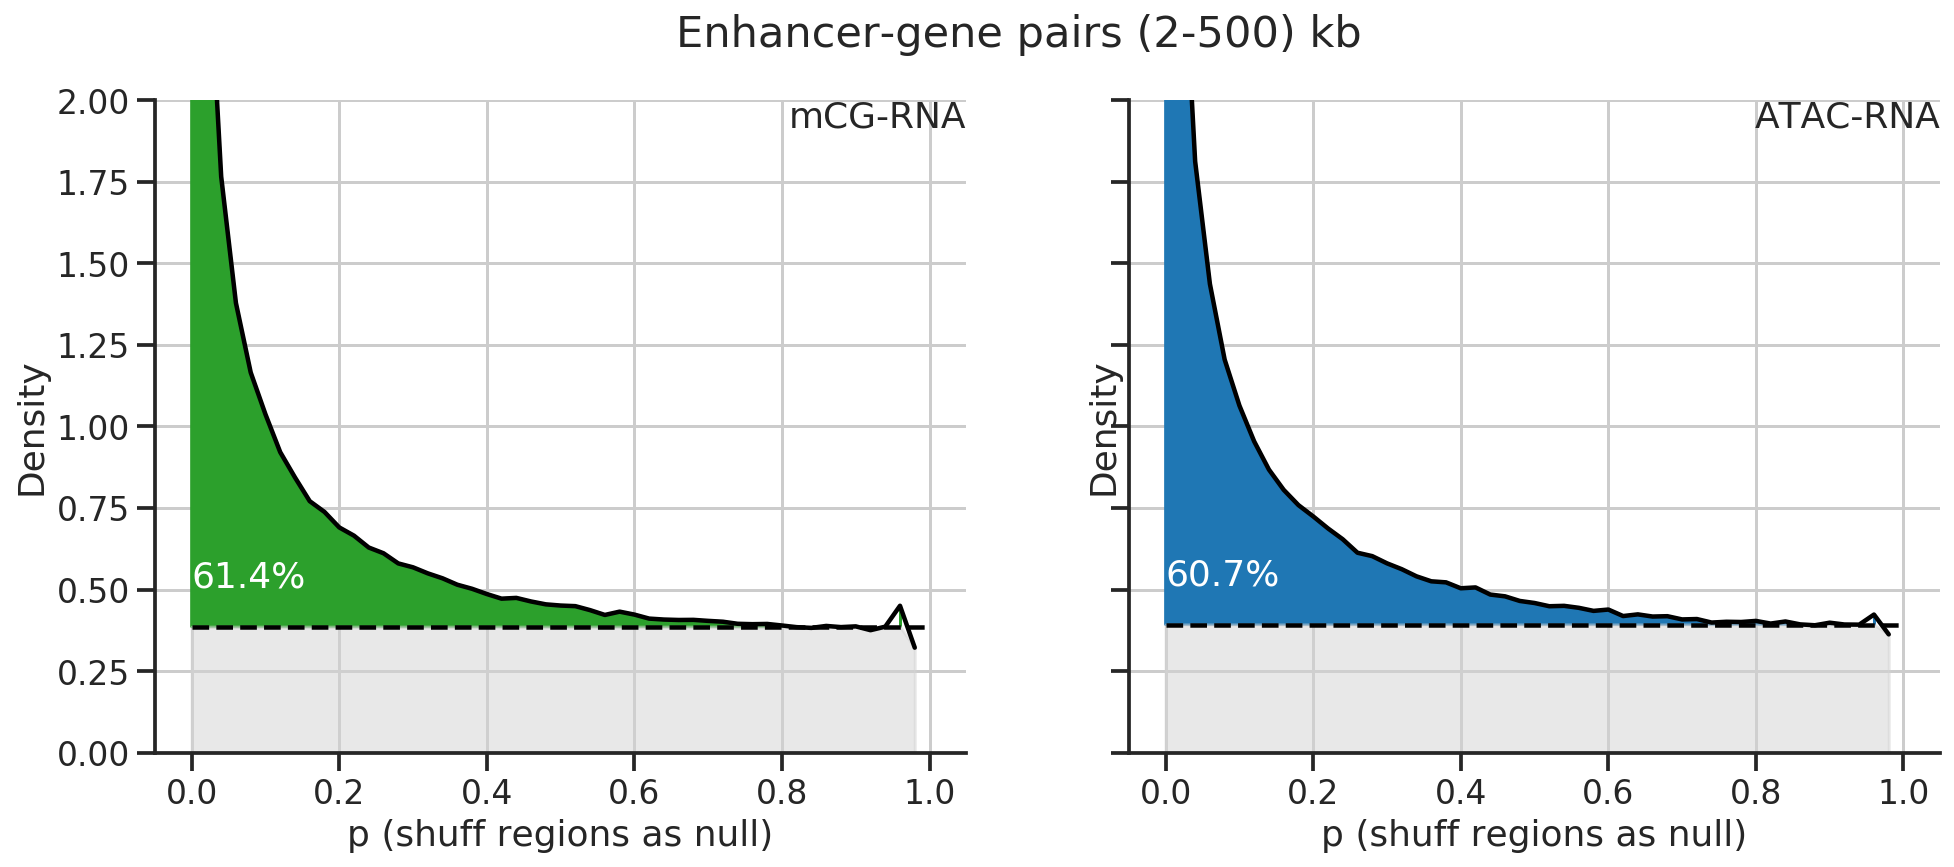

In [35]:
# plot pvalue distributions

ATAC_SIGN = -1
dist_th_this_plot = 5*1e5
bin_n = 51 
frac_bin_null = 0.1

pvals = [
    np.interp(res_corrs[res_corrs['dist']<dist_th_this_plot]['corr'], res_stats['bins'][1:], res_stats['correlated_pval']),
    np.interp(ATAC_SIGN*res2_corrs[res2_corrs['dist']<dist_th_this_plot]['corr'], res2_stats['bins'][1:], res2_stats['correlated_pval']),
]
labels = ['mCG-RNA', 'ATAC-RNA']
colors = [mod_palette['mc'], mod_palette['atac']]

fig, axs = plt.subplots(1, 2, figsize=(8*2,6), sharex=True, sharey=True)
for ax, pval, label, color in zip(axs, pvals, labels, colors):
    pipe_plot_pval_dist(ax, pval, bin_n=bin_n, frac_bin_null=frac_bin_null, fillcolor=color)
    ax.set_ylim([0, 2])
    ax.annotate(label, xy=(1,1), xycoords='axes fraction', ha='right', va='top')
    ax.set_xlabel('p (shuff regions as null)')
    ax.set_ylabel('Density')

fig.suptitle("Enhancer-gene pairs (2-500) kb")
fig.savefig(output_figures.format('hist_pval_correlated.pdf'), bbox_inches='tight')
plt.show()

501


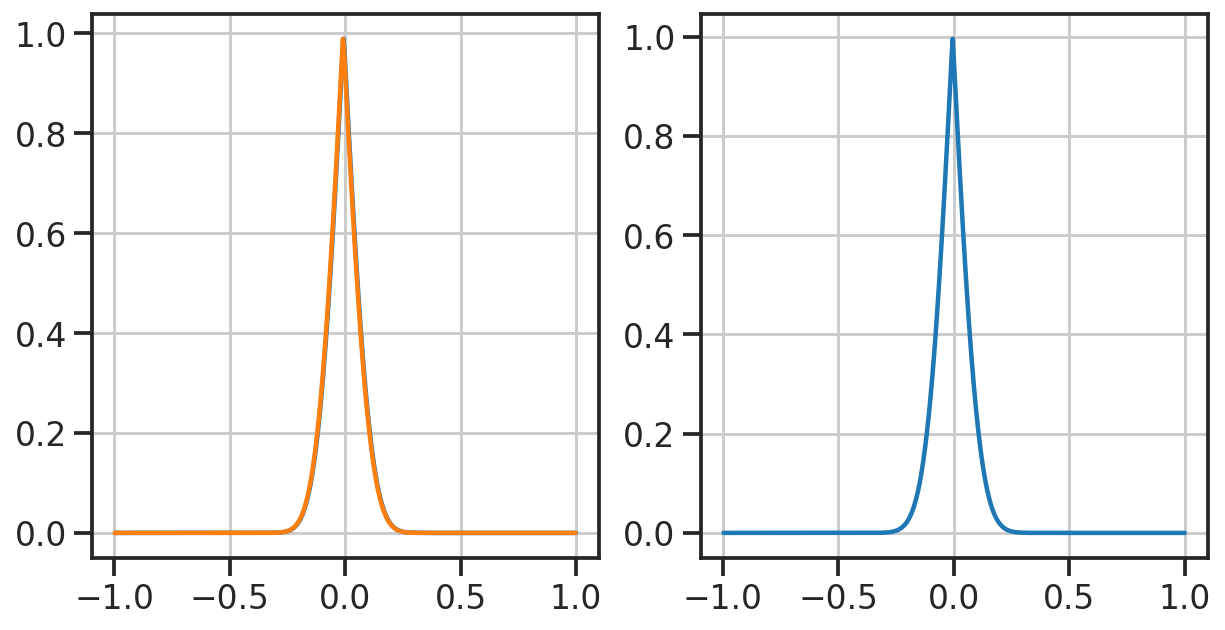

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(2*5,1*5))
ax = axs[0]
print(len(res_stats['bins']))
ax.plot(res_stats['bins'][1:], res_stats['correlated_pval'])
ax.plot((res_stats['bins'][:-1]+res_stats['bins'][1:])/2, res_stats['correlated_pval'])
# ax.plot(res_stats['bins'][:-1], res_stats['correlated_pval'])

ax = axs[1]
ax.plot(res2_stats['bins'][1:], res2_stats['correlated_pval'])
# ax.plot(res2_stats['bins'][:-1], res2_stats['correlated_pval'])

plt.show()

In [37]:
# simulate
# x = -1 + np.random.randn(100000)
x = 0 + np.random.randn(10)

bins = np.linspace(min(x), max(x), 5)
print(bins)
hist, _ = np.histogram(x, bins=bins, density=True)
cdf = np.cumsum(hist)/np.sum(hist)
pval = enhancer_gene_utils.cumfrac_to_pval(cdf, 'both')


len(bins), len(hist), len(cdf), len(pval)

print(bins)
print(_)





# fig, ax = plt.subplots()
# # sns.distplot(x, ax=ax)

# ax.plot(bins, [-1]*len(bins), 'sr')
# ax.scatter(x, [-1]*len(x))

# hist, _ = np.histogram(x, bins=bins)
# # ax.hist(bins[1:], hist)

# ax.plot((bins[:-1]+bins[1:])/2, hist, '-o')
# plt.show()

# hist

# # fig, axs = plt.subplots(3, 1, figsize=(1*5, 3*4))

# # sns.distplot(x, ax=axs[0])

# # axs[1].plot(bins[1:], cdf)

# # pipe_plot_pval_dist(axs[2], pval, bin_n=10, frac_bin_null=frac_bin_null, fillcolor=color)
# # plt.show()


[-1.6500234  -0.59114547  0.46773247  1.52661041  2.58548834]
[-1.6500234  -0.59114547  0.46773247  1.52661041  2.58548834]
[-1.6500234  -0.59114547  0.46773247  1.52661041  2.58548834]


In [38]:
def quantile_norm(array):
    return pd.Series(array).rank(pct=True, method='average').values

def estimate_frac_tps_vs_dists(dists_kb, res_corrs, res_stats, link_type, FLIP_CORR_SIGN, 
                               bin_n=51, frac_bin_null=0.1,
                              ):
    """Estimate the fraction of true positives with many different distance segments
    """
    frac_tps = []
    num_tps = []
    total_nums = []
    for idx in np.arange(len(dists_kb)):
        dist_kb = dists_kb[idx]
        if idx == 0:
            cond = (res_corrs['dist'] < dist_kb*KB)
        else:
            dist_kb_prev = dists_kb[idx-1]
            cond = ((res_corrs['dist'] < dist_kb*KB) & 
                    (res_corrs['dist'] >= dist_kb_prev*KB))

        if FLIP_CORR_SIGN: 
            corr_sign = -1
        else:
            corr_sign = 1

        pval = np.interp(corr_sign*res_corrs[cond]['corr'], 
                                res_stats['bins'][1:], res_stats[link_type])
        frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(pval, bin_n=bin_n, frac_bin_null=frac_bin_null)
        frac_tps.append(frac_tp)
        total_nums.append(len(pval))
        num_tps.append(len(pval)*frac_tp)
    return dists_kb, frac_tps, num_tps, total_nums

def estimate_num_sigs_vs_dists(fdr_th, dists_kb, res_corrs, res_stats, link_type, FLIP_CORR_SIGN):
    """Estimate the number of significant pairs with many different distance segments
    """
    frac_tps = []
    num_tps = []
    total_nums = []
    
    sig_gene_set = set()
    cum_sig_genes = []
    
    for idx in np.arange(len(dists_kb)):
        dist_kb = dists_kb[idx]
        if idx == 0:
            cond = (res_corrs['dist'] < dist_kb*KB)
        else:
            dist_kb_prev = dists_kb[idx-1]
            cond = ((res_corrs['dist'] < dist_kb*KB) & 
                    (res_corrs['dist'] >= dist_kb_prev*KB))

        if FLIP_CORR_SIGN: 
            corr_sign = -1
        else:
            corr_sign = 1

        pval = np.interp(corr_sign*res_corrs[cond]['corr'], 
                                res_stats['bins'][1:], res_stats[link_type])
        fdr = pval/quantile_norm(pval)
        
        total_num = len(pval)
        total_nums.append(total_num)
        
        sig_cond = fdr<fdr_th
        sig_genes = res_corrs[cond][sig_cond]['gene']
        sig_gene_set = sig_gene_set.union(set(list(sig_genes.values)))
        cum_sig_gene = len(sig_gene_set)
        cum_sig_genes.append(cum_sig_gene)
        
        num_tp = sig_cond.sum()
        num_tps.append(num_tp)
        
        frac_tp = num_tp/total_num
        frac_tps.append(frac_tp)
        
        
    return dists_kb, frac_tps, num_tps, total_nums, cum_sig_genes

In [39]:
# calc
dist_begin_kb = 2
dist_binsize = 20
fdr_th = fdr
dists_kb = np.hstack(np.arange(20, 1000+1, dist_binsize))
dists_kb_plot = np.hstack([[dist_begin_kb], dists_kb])


inputs = [
    (res_corrs, res_stats, 'linked_pval', False),
    (res2_corrs, res2_stats, 'linked_pval', True),
    (res_corrs, res_stats, 'correlated_pval', False),
    (res2_corrs, res2_stats, 'correlated_pval', True),
]
df_plots = []

bin_n = 51 # num bins in p level distribution
frac_bin_null = 0.1

for _input in inputs:
    
    _res_corrs, _res_stats, link_type, _flip = _input
    
#     if link_type == 'linked_pval':
#         bin_n = 51 # num bins in p level distribution
#         frac_bin_null = 0.05
#     elif link_type == 'correlated_pval':
#         bin_n = 51 # num bins in p level distribution
#         frac_bin_null = 0.1
    
    dists_kb, frac_tps, num_tps, total_nums = estimate_frac_tps_vs_dists(
            dists_kb, _res_corrs, _res_stats, 
            link_type,
            FLIP_CORR_SIGN=_flip, 
            bin_n=bin_n, frac_bin_null=frac_bin_null,)
    dists_kb, sig_frac_tps, sig_num_tps, sig_total_nums, cum_sig_genes = estimate_num_sigs_vs_dists(
            fdr_th, dists_kb, _res_corrs, _res_stats, 
            link_type,
            FLIP_CORR_SIGN=_flip)
    
    # organize results
    mats = np.vstack([
                dists_kb, 
                frac_tps, num_tps, total_nums,
                sig_frac_tps, sig_num_tps, sig_total_nums, cum_sig_genes,
                ]).T 
    cols = ['dist', 
            'frac_tp', 'num_pos', 'num_total', 
            'sig_frac_tp', 'sig_num_pos', 'sig_num_total', 'cum_sig_genes',
           ] 
    df_plot = pd.DataFrame(mats, columns=cols) 
#     df_plot['length'] = [dists_kb_plot[i+1] - dists_kb_plot[i] for i in range(len(dists_kb))]
#     df_plot['num_pos_norm'] = df_plot['num_pos']/df_plot['length']
#     df_plot['sig_num_pos_norm'] = df_plot['sig_num_pos']/df_plot['length']
    
    df_plots.append(df_plot)

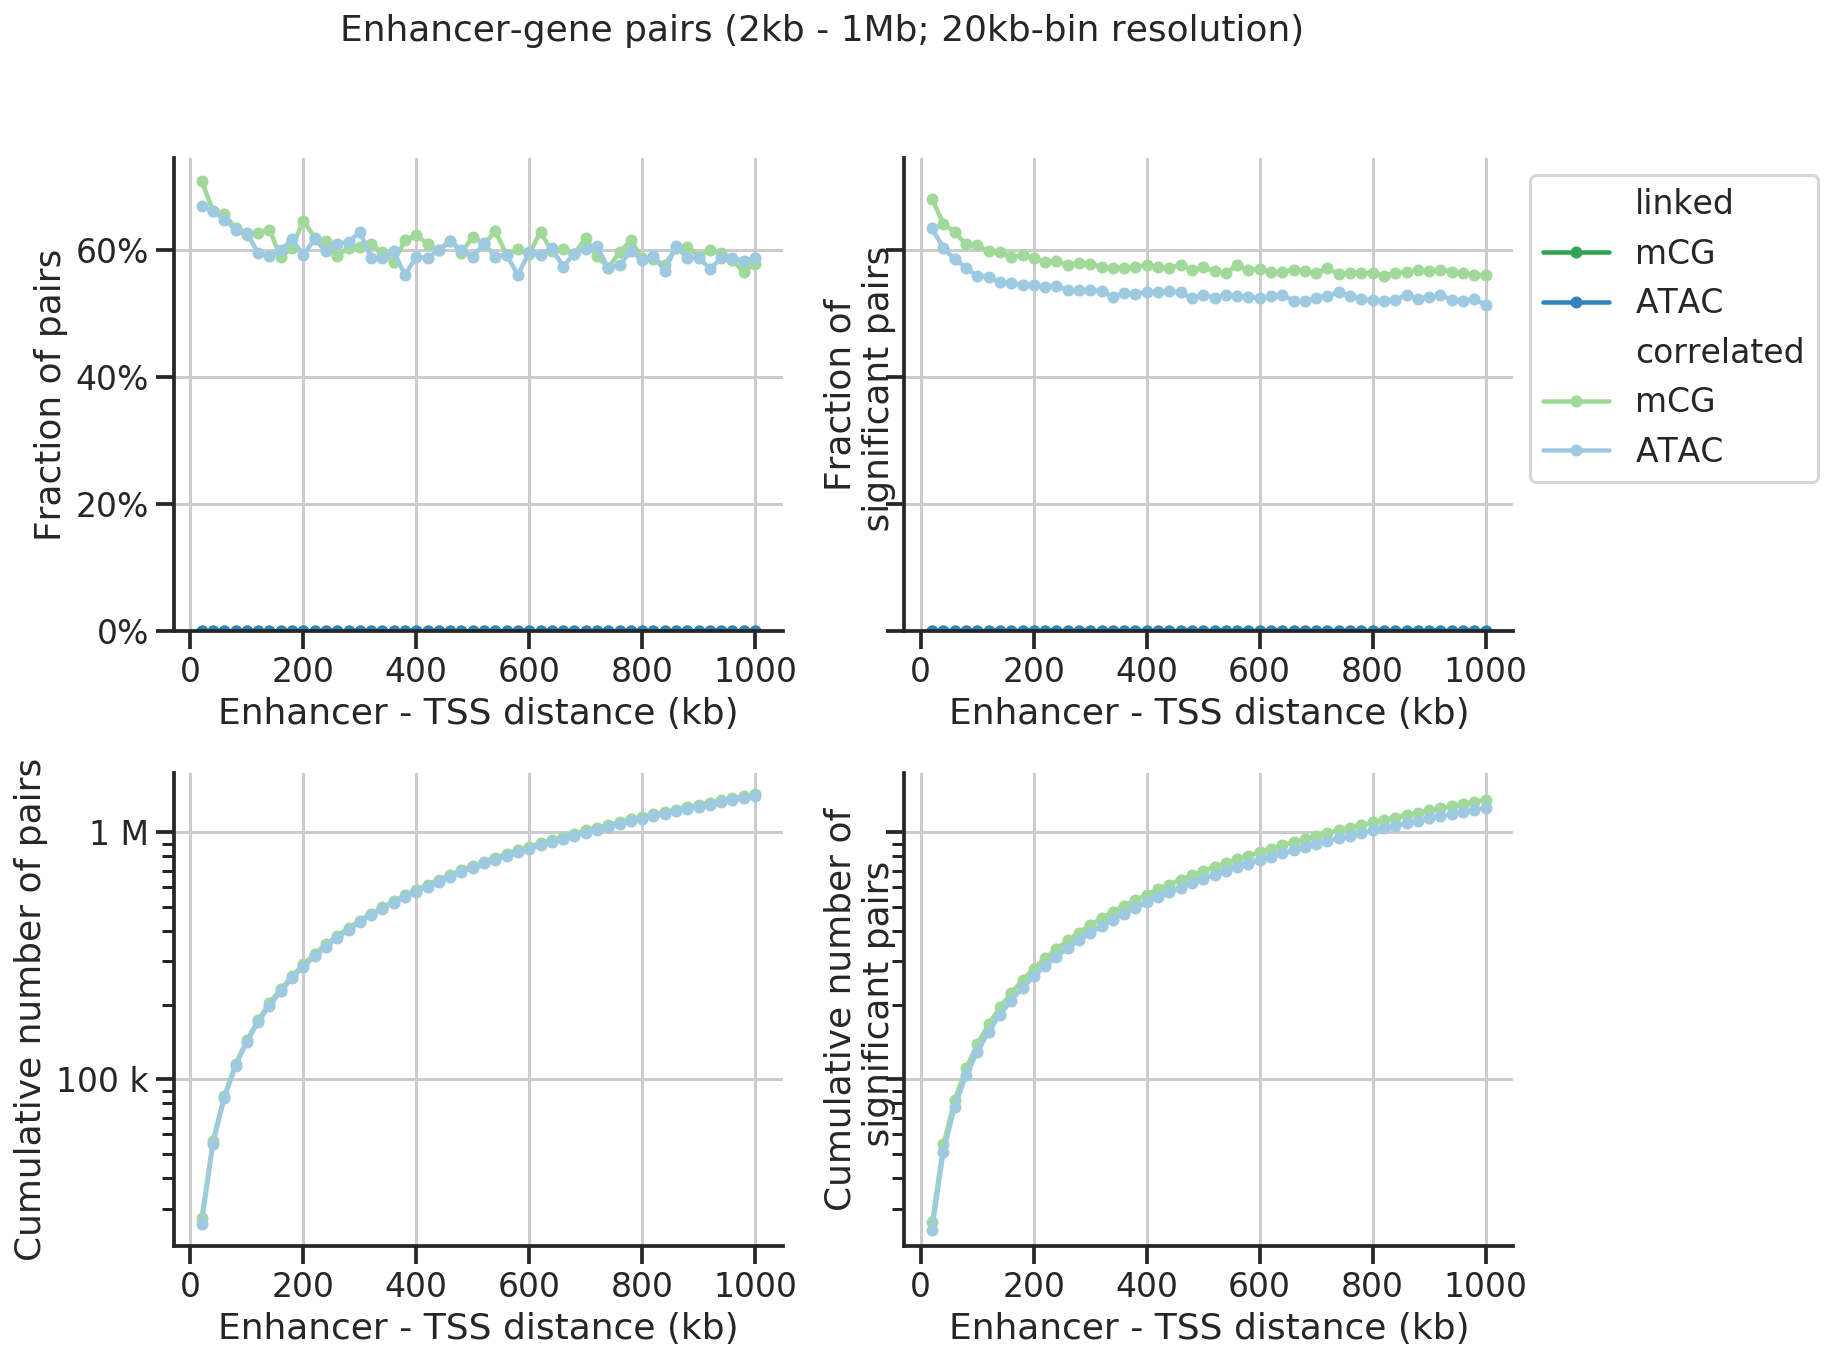

In [40]:
# prep

# one plot
colors = [
    mod_palette_comp['mc'][0], mod_palette_comp['atac'][0], 
    mod_palette_comp['mc'][2], mod_palette_comp['atac'][2], 
    ]
labels = [
    'mCG linked', 'ATAC linked', 
    'mCG correlated', 'ATAC correlated', 
    ]

# all plots
subplot_cols = [
    'frac_tp', 
    'sig_frac_tp', 
    
    'num_pos',
    'sig_num_pos',
]
subplot_labels = [
    'Fraction of pairs', 
    'Fraction of\n significant pairs', 
    
    'Cumulative number of pairs',
    'Cumulative number of\n significant pairs',
    ]
tracks_all = [
    [(df_plot['dist'], df_plot[subplot_cols[0]]) for df_plot in df_plots],
    [(df_plot['dist'], df_plot[subplot_cols[1]]) for df_plot in df_plots],
    [(df_plot['dist'], np.cumsum(df_plot[subplot_cols[2]])) for df_plot in df_plots],
    [(df_plot['dist'], np.cumsum(df_plot[subplot_cols[3]])) for df_plot in df_plots],
]

# plot
fig, axs = plt.subplots(2, 2, figsize=(6*2,5*2), sharex=False, sharey='row')
r = EMPTY_RECTANGLE
for i, (ax, tracks_subplot, subplot_label) in enumerate(zip(
        axs.flat, tracks_all, subplot_labels)):
    for track, color, label in zip(tracks_subplot, colors, labels):
        _x, _y = track
        ax.plot(_x, _y, '-o', color=color, label=label, markersize=5)
        
    sns.despine(ax=ax)
    ax.set_xlabel('Enhancer - TSS distance (kb)')
    ax.set_ylabel(subplot_label)
    if i in [0, 1]:
        ax.set_ylim(ymin=0)
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) 
    if i in [2, 3]:
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(mtick.EngFormatter()) 

# work on legends
handles, labels = ax.get_legend_handles_labels()
labels = [label.split(' ')[0] for label in labels]
handles = [r] + handles[:2] + [r] + handles[2:]
labels = ['linked'] + labels[:2] + ['correlated'] + labels[2:]
axs.flat[1].legend(handles, labels, 
                      bbox_to_anchor=(1,1), loc='upper left', 
                     )
fig.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle('Enhancer-gene pairs (2kb - 1Mb; {}kb-bin resolution)'.format(dist_binsize), 
             fontsize=18,
            )
fig.savefig(output_figures.format('plot_stats_vs_dist.pdf'), bbox_inches='tight')
plt.show()

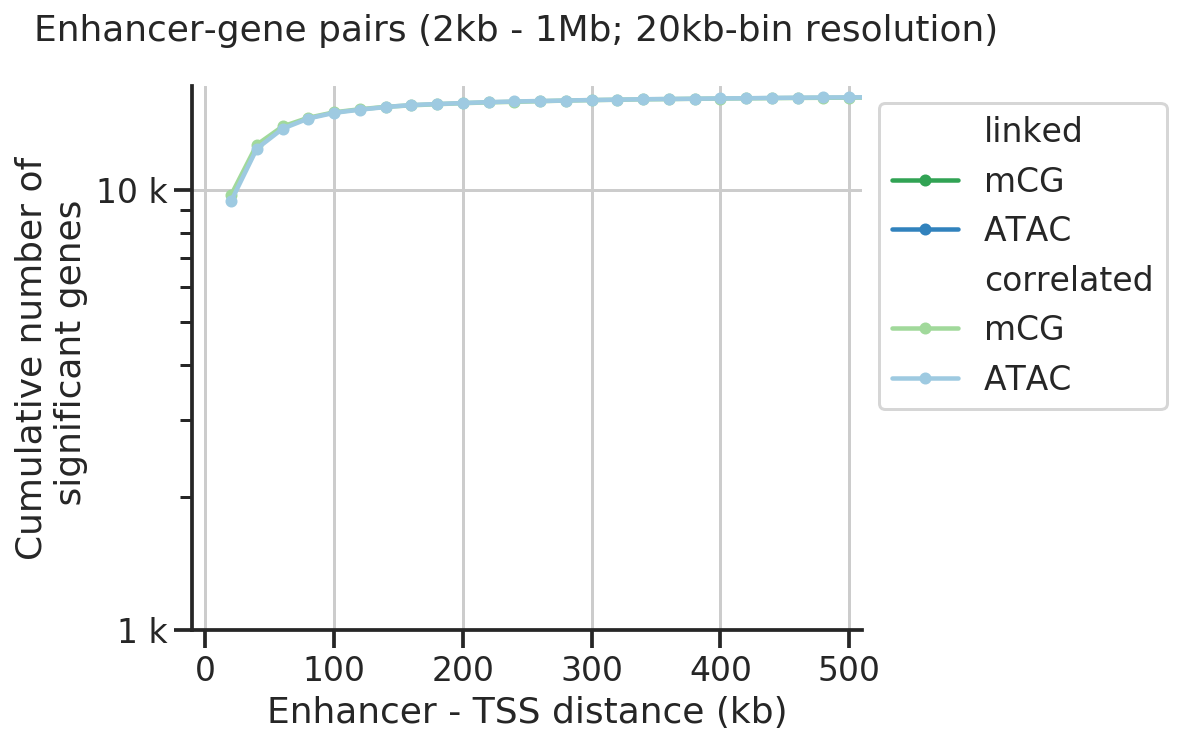

In [41]:
# prep

# one plot
colors = [
    mod_palette_comp['mc'][0], mod_palette_comp['atac'][0], 
    mod_palette_comp['mc'][2], mod_palette_comp['atac'][2], 
    ]
labels = [
    'mCG linked', 'ATAC linked', 
    'mCG correlated', 'ATAC correlated', 
    ]

# all plots
subplot_cols = [
    'cum_sig_genes',
]
subplot_labels = [
    'Cumulative number of\n significant genes',
    ]
tracks_all = [
    [(df_plot['dist'], df_plot[subplot_col]) for df_plot in df_plots]
    for subplot_col in subplot_cols
]

# plot
fig, axs = plt.subplots(1, 1, figsize=(6,5))
r = EMPTY_RECTANGLE
for i, (ax, tracks_subplot, subplot_label) in enumerate(zip(
        [axs], tracks_all, subplot_labels)):
    for track, color, label in zip(tracks_subplot, colors, labels):
        _x, _y = track
        ax.plot(_x, _y, '-o', color=color, label=label, markersize=5)
        
    sns.despine(ax=ax)
    ax.set_xlabel('Enhancer - TSS distance (kb)')
    ax.set_ylabel(subplot_label)
    ax.set_xlim(xmin=-10, xmax=510)
    ax.set_ylim(ymin=1000)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(mtick.EngFormatter()) 

# work on legends
handles, labels = ax.get_legend_handles_labels()
labels = [label.split(' ')[0] for label in labels]
handles = [r] + handles[:2] + [r] + handles[2:]
labels = ['linked'] + labels[:2] + ['correlated'] + labels[2:]
ax.legend(handles, labels, 
                      bbox_to_anchor=(1,1), loc='upper left', 
                     )
# fig.subplots_adjust(wspace=0.2)
fig.suptitle('Enhancer-gene pairs (2kb - 1Mb; {}kb-bin resolution)'.format(dist_binsize), 
             fontsize=18,
            )
fig.savefig(output_figures.format('plot_cumsig_gene_vs_dist.pdf'), bbox_inches='tight')
plt.show()

### Plot corr dist

In [42]:
labels_base = [
          'shuffled cell types',
          'shuffled regions',
          '<500kb',
          '<100kb',
         ] 
subsample_rates = [
                  1,
                  1,
                  1,
                  1,
                 ]


# corr1
labels = [label+' mCG-RNA' for label in labels_base]
corr_tracks = [
       res_corrs['corr_shuff_cells'].values,
       res_corrs['corr_shuff'].values,
       res_corrs.loc[res_corrs['dist']<=500*KB, 'corr'].values,
       res_corrs.loc[res_corrs['dist']<=100*KB, 'corr'].values,
    
#        corr.flatten(),
#        corr_cis,
      ]
colors = [colors_null[1], colors_null[0], colors_mc[1], colors_mc[0],]
vertical_lines = [
    res_stats['r_th_linked'],
    res_stats['r_th_correlated_left'],
    res_stats['r_th_correlated_right'],
]

# corr2
labels2 = [label+' ATAC-RNA' for label in labels_base]
corr_tracks2 = [
       res2_corrs['corr_shuff_cells'].values,
       res2_corrs['corr_shuff'].values,
       res2_corrs.loc[res2_corrs['dist']<=500*KB, 'corr'].values,
       res2_corrs.loc[res2_corrs['dist']<=100*KB, 'corr'].values,
    
#        corr.flatten(),
#        corr_cis,
      ]
colors2 = [colors_null[1], colors_null[0], colors_atac[1], colors_atac[0],]
vertical_lines2 = [
    ATAC_SIGN*res2_stats['r_th_linked'],
    ATAC_SIGN*res2_stats['r_th_correlated_left'],
    ATAC_SIGN*res2_stats['r_th_correlated_right'],
]

np.random.seed(0)
corr_tracks = [corr_tracks[i][np.random.rand(len(corr_tracks[i])) < subsample_rates[i]] 
               for i in range(len(corr_tracks))]
corr_tracks2 = [corr_tracks2[i][np.random.rand(len(corr_tracks2[i])) < subsample_rates[i]] 
               for i in range(len(corr_tracks2))]


In [43]:
# plot distribution
def plot_dist_both(
    colors, corr_tracks, labels, vertical_lines, 
    colors2, corr_tracks2, labels2, vertical_lines2, 
    bins,
    subsample_rates,
    fancy=True,
    output='',
    ):
    """
    """
    
    with sns.axes_style('ticks', {'axes.grid': False}):
        fig, axs = plt.subplots(2, 1, figsize=(7*1,4*2), sharex=False)
        for i, ax in enumerate(axs):
            if i == 0:
                _colors = colors
                _corr_tracks = corr_tracks
                _labels = labels
                _vertical_lines = vertical_lines
            elif i == 1:
                _colors = colors2
                _corr_tracks = corr_tracks2
                _labels = labels2
                _vertical_lines = vertical_lines2
            fontsize = ax.xaxis.label.get_fontsize()

            # each line (color) is present in all columns; loop over lines
            ax = axs[i]
            histy_max = 0
            for j, (_x, label, color, subsample_rate) in enumerate(zip(
                    _corr_tracks, _labels, _colors, subsample_rates)):
                # go over columns
                label_comp = '{} ({}, frac={})'.format(label, len(_x), subsample_rate)

                g = ax.hist(_x, bins=bins, 
                            histtype='step', 
                            label=label,
                            color=color, density=True)
                histy, histx, _ = g
                if j == 0:
                    histy0_max = np.max(histy)
                    histx0_max = bins[np.argmax(histy)]
                if j > 0:
                    histy_max = max(histy_max, np.max(histy)) 

            ax.set_ylim([0, 1.3*histy_max])
            if histy0_max > 1.3*histy_max:
                # text
                text_config = {
                    'xy': (histx0_max, 1.3*histy_max), 
                    'ha': 'center', 'va': 'bottom', 
                    'xytext': (0, 0),
                    'textcoords': 'offset points',
                    'fontsize': 0.7*fontsize,
                }
                ax.annotate("{:.2f}".format(histy0_max), **text_config)

            # labels
            if i == 1:
                ax.set_xlabel('Spearman correlation')
            ax.set_ylabel('Density')
            ax.set_xlim([-1, 1])
            sns.despine(ax=ax)

            # line ticks
            ax.grid(which='major', axis='x', linestyle='--')
            ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.2f}'))
            ax.set_xticks(np.sort(np.hstack([[-1, 0, 1], _vertical_lines])))

            # horizontal lines
            lineys = [1.1*histy_max, 1.2*histy_max, 1.2*histy_max]
            linecolors = ['k', 'gray', 'gray']
            texts = ['linked', 'correlated', 'correlated']
            vas = ['top', 'bottom', 'bottom']
            offsets = [(0.2*fontsize, -0.2*fontsize), 
                       (0.2*fontsize, +0.2*fontsize), 
                       (0.2*fontsize, +0.2*fontsize), 
                      ]
            for xcoord, linecolor, liney, text, va, offset in zip(
                _vertical_lines, linecolors, lineys, texts, vas, offsets):
                if xcoord < 0:
                    _x = -1
                    xmin, xmax = -1, xcoord
                    ha = 'left'
                else:
                    _x = 1
                    xmin, xmax = xcoord, 1 
                    ha = 'right'
                # line
                ax.hlines(liney, xmin=xmin, xmax=xmax, color=linecolor, linestyle='-')
                # text
                text_config = {
                    'xy': (_x, liney), 
                    'ha': ha, 'va': va, 
                    'xytext': offset,
                    'textcoords': 'offset points',
                    'fontsize': fontsize,
                }
                ax.annotate(text, **text_config)

        if fancy:
            # title
            axs[0].set_title('mCG-RNA', y=1.1)
            axs[1].set_title('ATAC-RNA', y=1.1)
            
            # combined legend
            r = EMPTY_RECTANGLE
            handles, labels = snmcseq_utils.combine_legends(axs.flat)
            handles = list(handles)
            labels = list(labels)
            # line orders
            _labels = [" ".join(label.split(' ')[:-1])for label in labels]
            _handles = [r] + handles[:4] + [r] + handles[4:]
            # turn it into lines
            _handles = [mpl.lines.Line2D([], [], c=h.get_edgecolor()) for h in _handles]
            _labels = ['mCG-RNA'] + ['']*4 + ['ATAC-RNA'] + _labels[4:]
            axs[0].legend(_handles, _labels, ncol=2,
                      bbox_to_anchor=(1,1), loc='upper left')
            
            # text
            text_config = {
                'xy': (1, 0.5*histy_max), 
                'ha': 'right', 'va': 'top', 
                'xytext': (0, 0),
                'textcoords': 'offset points',
                'fontsize': 0.7*fontsize,
            }
            ax.annotate('FDR={:.2f}'.format(fdr_th), **text_config)

        # adjust
        fig.subplots_adjust(hspace=0.5)
        # savefig
        if output:
            fig.savefig(output, bbox_inches='tight')
        plt.show()

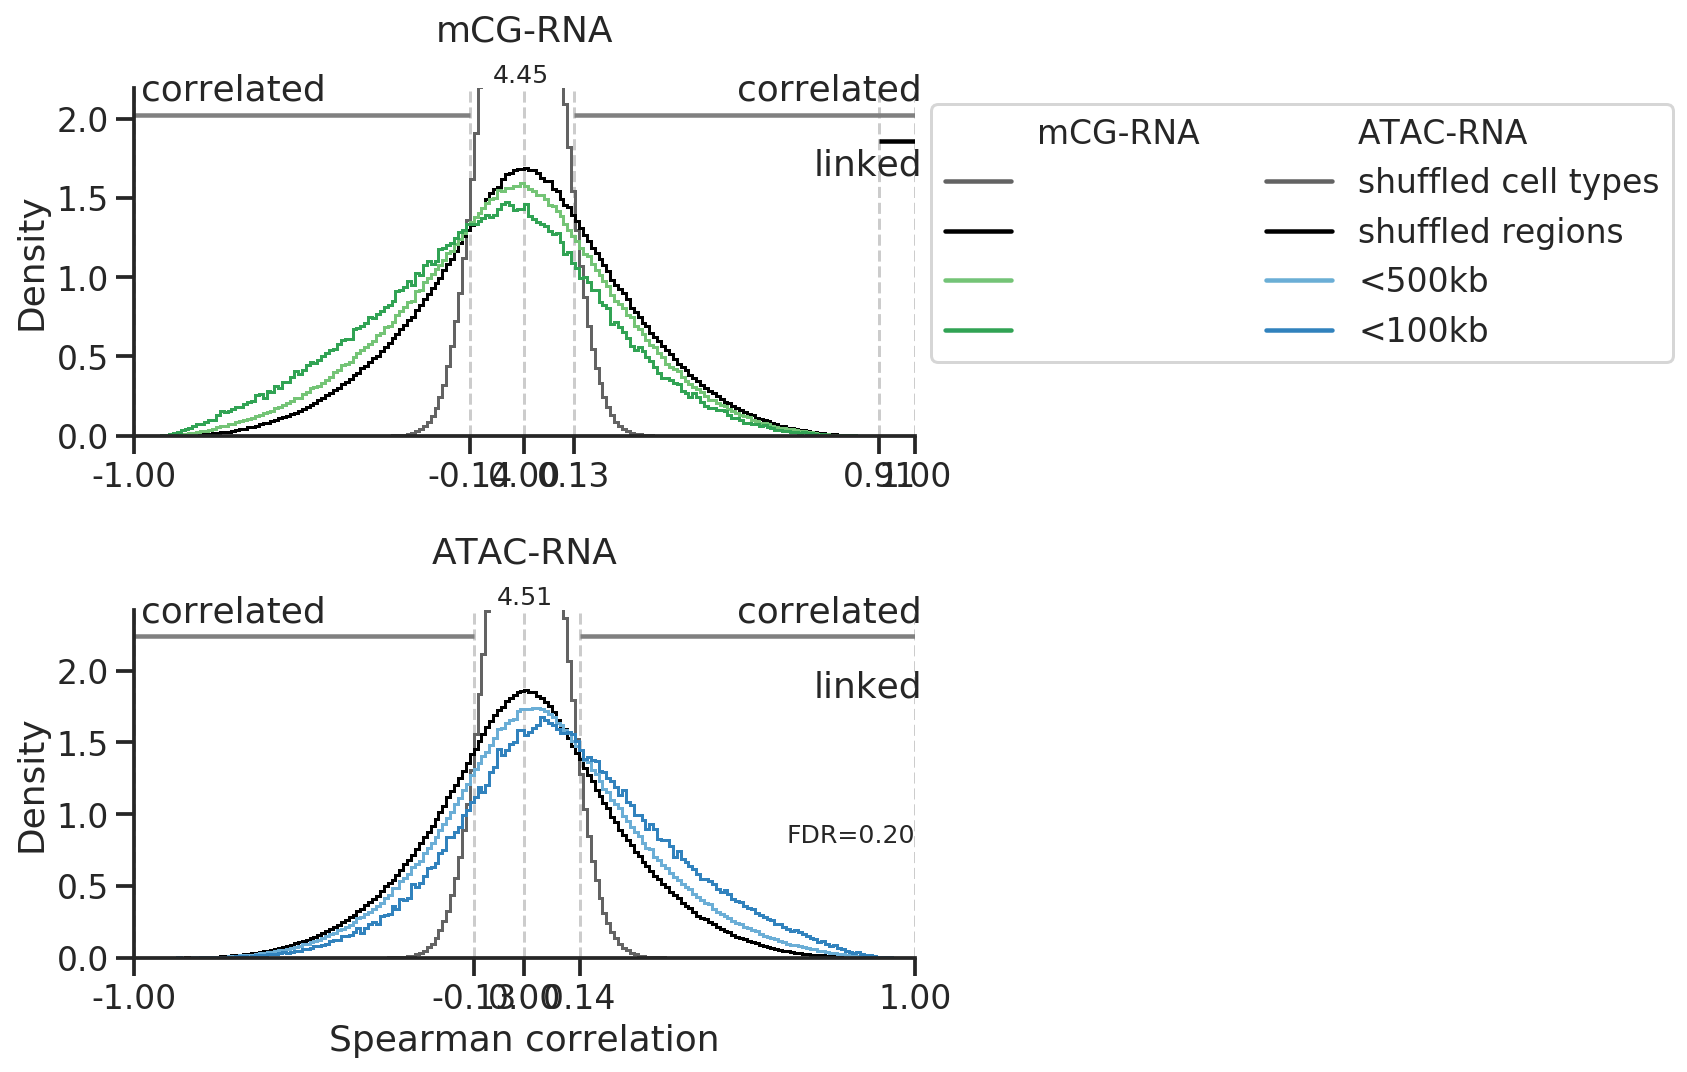

In [44]:
output = output_figures.format('hist_corr_both.pdf')

bins = np.linspace(-1, 1, 201)

plot_dist_both(
    colors, corr_tracks, labels, vertical_lines, 
    colors2, corr_tracks2, labels2, vertical_lines2, 
    bins,
    subsample_rates,
    fancy=True,
    output=output,
    )

### 2D density ATAC vs mC

In [45]:
res_corrs_comb = res_corrs.join(res2_corrs.set_index(['gene', 'enh', 'dist', 'is_in_genebody']), 
                                on=['gene', 'enh', 'dist', 'is_in_genebody'], 
                                lsuffix='_mc', rsuffix='_atac').astype({'enh': int})
res_corrs_comb['corr_both'] = res_corrs_comb['corr_mc'] + (-res_corrs_comb['corr_atac'])
res_corrs_comb = res_corrs_comb.sort_values('corr_both')
print(res_corrs_comb.shape)
res_corrs_comb.head()



(2340530, 11)


,gene,enh,dist,is_in_genebody,corr_mc,corr_shuff_mc,corr_shuff_cells_mc,corr_atac,corr_shuff_atac,corr_shuff_cells_atac,corr_both
1755832,ENSMUSG00000051456,65587,3042,False,-0.917170,0.105743,-0.083876,0.932441,-0.138631,0.081064,-1.849610
13097,ENSMUSG00000000632,37855,5669,True,-0.941956,-0.233343,-0.005172,0.902612,-0.044887,0.156646,-1.844568
1197762,ENSMUSG00000034584,221472,656806,False,-0.917268,-0.192459,-0.119500,0.927207,-0.307169,0.140865,-1.844474
226568,ENSMUSG00000018634,40650,44012,False,-0.927403,0.228839,-0.048367,0.915208,-0.467048,-0.007299,-1.842611
226554,ENSMUSG00000018634,40631,49572,False,-0.918477,0.236485,-0.064726,0.918989,-0.354447,-0.024636,-1.837466


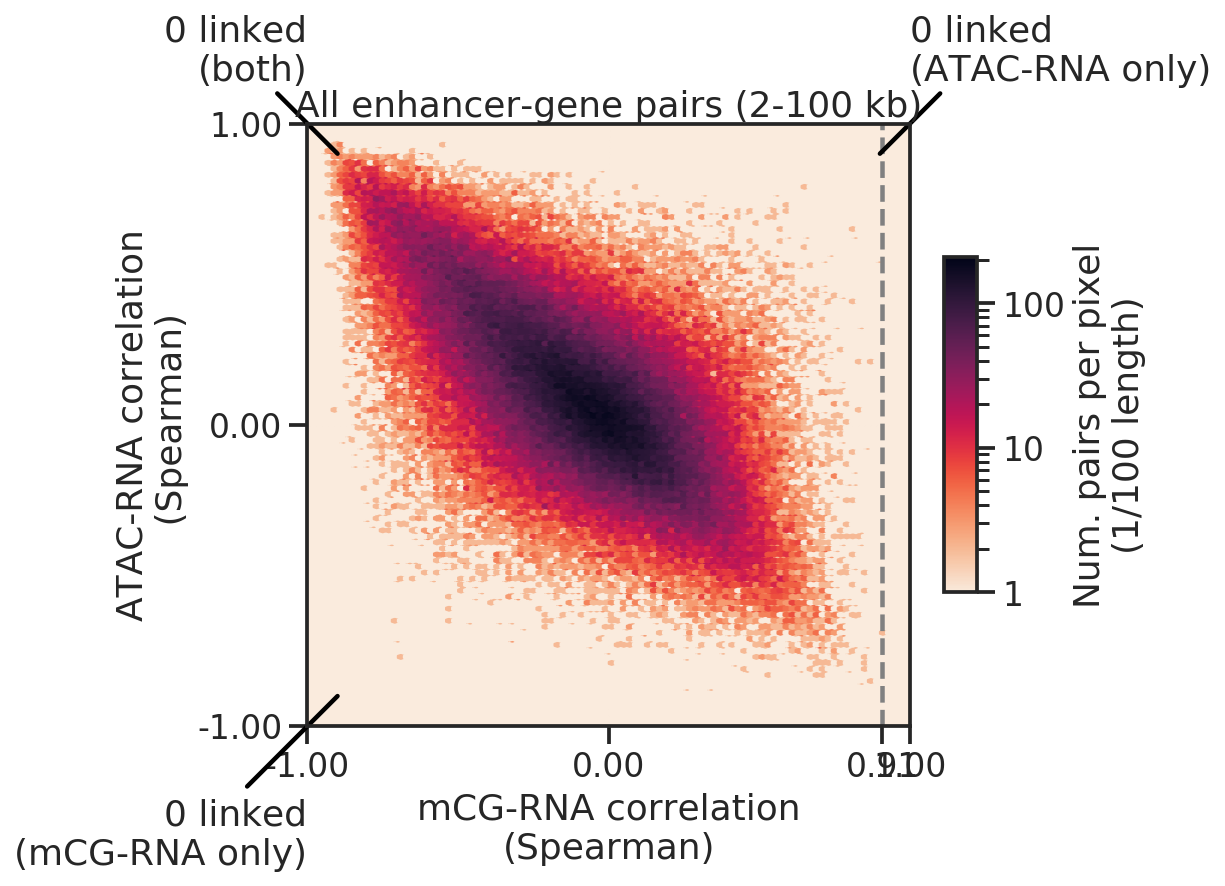

In [46]:
# prep
_table = res_corrs_comb[res_corrs_comb['dist']<1e5]
_x = _table['corr_mc'].values
_y = _table['corr_atac'].values
r_mc, r_atac = res_stats['r_th_linked'], ATAC_SIGN*res2_stats['r_th_linked'] #-0.5, 0.5
# cond_mc = _table['corr_mc'] < r_mc
# cond_atac = _table['corr_atac'] > r_atac

sets = [
    set(res_stats['linked_table'].index.values),
    set(res2_stats['linked_table'].index.values),
]
num_sig_both = len(sets[0] & sets[1])
num_sig_mc = len(sets[0]) - num_sig_both
num_sig_atac = len(sets[1]) - num_sig_both

# plot
fig, ax = plt.subplots(figsize=(6, 6))
g = ax.hexbin(_x, _y,  
              gridsize=(100,100),
              extent=(-1,1,-1,1),
              cmap='rocket_r', 
              bins='log', # log10(i+1)
              rasterized=True,
             )
ax.axhline(r_atac, color='gray', linestyle='--', zorder=2)
ax.axvline(r_mc, color='gray', linestyle='--', zorder=2)
ax.set_aspect('equal')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])  
ax.set_xticks(np.sort([-1, 0, 1, r_mc]))
ax.set_yticks(np.sort([-1, 0, 1, r_atac]))
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter("%.2f"))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.2f"))
ax.set_xlabel('mCG-RNA correlation\n(Spearman)')
ax.set_ylabel('ATAC-RNA correlation\n (Spearman)')
ax.set_title('All enhancer-gene pairs (2-100 kb)', pad=0)

# annotate
ax.annotate("{} linked\n(mCG-RNA only)".format(num_sig_mc), 
            xy=(0,0), xycoords='axes fraction',
            xytext=(0, -2*ax.xaxis.label.get_fontsize()), textcoords='offset points',
            ha='right', va='top',
            fontsize=ax.title.get_fontsize(),
           )
ax.annotate("{} linked\n(ATAC-RNA only)".format(num_sig_atac), 
            xy=(1,1), xycoords='axes fraction',
            xytext=(0, +ax.title.get_fontsize()), textcoords='offset points',
            ha='left', va='bottom',
            fontsize=ax.title.get_fontsize(),
           )
ax.annotate("{} linked\n(both)".format(num_sig_both), 
            xy=(0,1), xycoords='axes fraction',
            xytext=(0, +ax.title.get_fontsize()), textcoords='offset points',
            ha='right', va='bottom',
            fontsize=ax.title.get_fontsize(),
           )

# lines
ax.plot([-1.2,-0.9], [-1.2, -0.9], color='k', clip_on=False)
ax.plot([1.1,0.9], [1.1, 0.9], color='k', clip_on=False)
ax.plot([-1.1,-0.9], [1.1, 0.9], color='k', clip_on=False)


# cbar
cbar = fig.colorbar(g, ax=ax, 
                     fraction=0.05, aspect=10,
                     label='Num. pairs per pixel\n(1/100 length)')
cbar.ax.yaxis.set_major_formatter(mtick.EngFormatter())
snmcseq_utils.savefig(fig, output_figures.format('scatter_corr_mcrna_atacrna.pdf'))
plt.show()

### Nums enhancer vs nums genes 

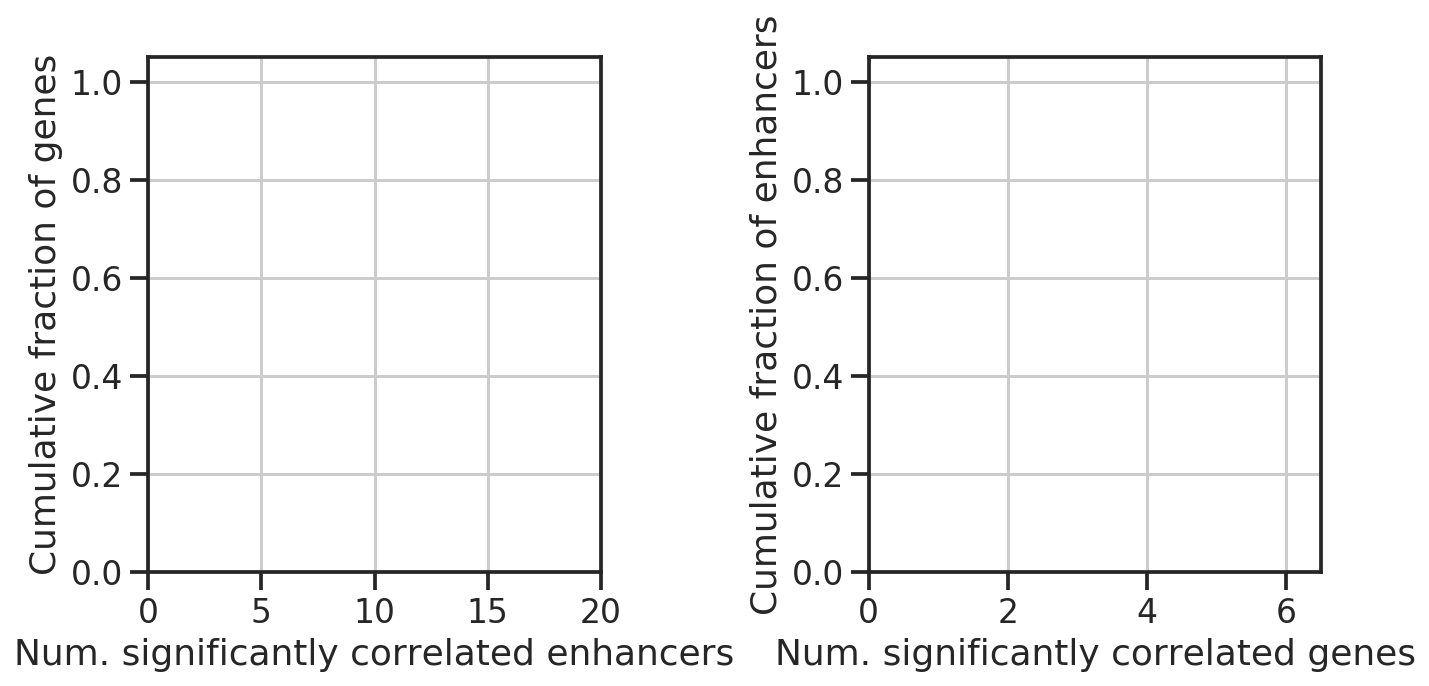

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(5*2,5*1))
ax = axs[0]
for mod, _df in zip(['mc', 'atac'], 
                    [df_nngene, df2_nngene], 
                    ):
    a = _df.groupby('gene').size().sort_values() #.values
    a = a.value_counts().sort_index() #.values
    a = a[a>0]
    a = a/a.sum()
    a = np.cumsum(a)
    
    ax.plot(a.index.values, a.values, '-o', color=mod_palette[mod])
    
ax.set_xlabel('Num. significantly correlated enhancers')
ax.set_ylabel('Cumulative fraction of genes')
ax.set_xlim([0, 20])
ax.set_ylim([0, 1.05])

ax = axs[1]
for mod, _df in zip(['mc', 'atac'], 
                    [df_nngene, df2_nngene], 
                    ):
    a = _df.groupby('enh').size().sort_values() #.values
    a = a.value_counts().sort_index() #.values
    a = a[a>0]
    a = a/a.sum()
    a = np.cumsum(a)
    ax.plot(a.index.values, a.values, '-o', color=mod_palette[mod])
    
ax.set_xlabel('Num. significantly correlated genes')
ax.set_ylabel('Cumulative fraction of enhancers')
ax.set_xlim([0, 6.5])
ax.set_ylim([0, 1.05])



fig.tight_layout()
fig.savefig(output_figures.format('cdf_gene_enh_num_dist.pdf'), bbox_inches='tight')

### stacked barplot -- num enh linked by mCG-RNA vs by ATAC-RNA 

In [ ]:
a = df_nngene.groupby('gene').size().sort_values(ascending=False)
b = df2_nngene.groupby('gene').size().sort_values(ascending=False)
c = pd.merge(df_nngene, df2_nngene, 
         on=['gene', 'enh'], 
         ).groupby('gene').size().sort_values(ascending=False)

linked_genes_summary = (pd.concat([a, b, c], axis=1)
                            .rename(columns={0:'mCG', 1:'ATAC', 2:'both'})
                            .fillna(0).astype(int)
                       )
linked_genes_summary['either'] = linked_genes_summary[['mCG', 'ATAC']].sum(axis=1) - linked_genes_summary['both']
linked_genes_summary['mCG only'] = linked_genes_summary['mCG'] - linked_genes_summary['both']
linked_genes_summary['ATAC only'] = linked_genes_summary['ATAC'] - linked_genes_summary['both']
linked_genes_summary = linked_genes_summary.sort_values('either', ascending=False)
linked_genes_summary.index = gid_to_gname[linked_genes_summary.index] 
print(linked_genes_summary.shape)
linked_genes_summary.head()

In [ ]:
# numbers 
cols = ['both', 'mCG only', 'ATAC only'] 
colors = ['lightgray', mod_palette['mc'], mod_palette['atac']]
with sns.axes_style({
#                      'patch.force_edgecolor': False,
                     'patch.edgecolor': 'k',
                     'grid.linestyle': '',
                    }):
    fig, ax = plt.subplots(figsize=(9,4))
    (linked_genes_summary[cols]
             .head(30)
             .plot.bar(stacked=True, width=0.8, alpha=1, ax=ax, color=colors)
        )
    ax.set_xlabel('Gene')
    ax.set_ylabel('Number of linked enhancers')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    sns.despine(ax=ax)
    snmcseq_utils.savefig(fig, output_figures.format('bar_gene_num_enh_mc_atac_both.pdf'))
    plt.show()

### stacked barplot -- intra- vs inter-genic 

In [ ]:
a = (df_nngene.groupby(['gene', 'is_in_genebody']).size().unstack().fillna(0).astype(int)
              .rename(columns={False: "mCG 0", True: "mCG 1"}) 
    )
b = (df2_nngene.groupby(['gene', 'is_in_genebody']).size().unstack().fillna(0).astype(int)
               .rename(columns={False: "ATAC 0", True: "ATAC 1"}) 
    )
c = (pd.merge(df_nngene, df2_nngene, 
         on=['gene', 'enh'])
         .groupby(['gene', 'is_in_genebody_x']).size().unstack().fillna(0).astype(int)
         .rename(columns={False: "both 0", True: "both 1"}) 
    )

linked_genes_summary_detail = pd.concat([a, b, c], axis=1).fillna(0).astype(int) #.rename(columns={False: 'cC'})
print(linked_genes_summary_detail.shape)
linked_genes_summary_detail.head()

In [ ]:
linked_genes_summary_detail['either 0'] = (linked_genes_summary_detail[['mCG 0', 'ATAC 0']].sum(axis=1) 
                                           - linked_genes_summary_detail['both 0']
                                          )
linked_genes_summary_detail['either 1'] = (linked_genes_summary_detail[['mCG 1', 'ATAC 1']].sum(axis=1) 
                                           - linked_genes_summary_detail['both 1']
                                          )
linked_genes_summary_detail['either'] = linked_genes_summary_detail['either 0'] + linked_genes_summary_detail['either 1']

linked_genes_summary_detail['mCG only 0'] = linked_genes_summary_detail['mCG 0'] - linked_genes_summary_detail['both 0']
linked_genes_summary_detail['mCG only 1'] = linked_genes_summary_detail['mCG 1'] - linked_genes_summary_detail['both 1']

linked_genes_summary_detail['ATAC only 0'] = linked_genes_summary_detail['ATAC 0'] - linked_genes_summary_detail['both 0']
linked_genes_summary_detail['ATAC only 1'] = linked_genes_summary_detail['ATAC 1'] - linked_genes_summary_detail['both 1']


linked_genes_summary_detail = linked_genes_summary_detail.sort_values('either', ascending=False)
linked_genes_summary_detail.index = gid_to_gname[linked_genes_summary_detail.index] 
print(linked_genes_summary_detail.shape)
linked_genes_summary_detail.head()

In [ ]:
# numbers 
import matplotlib

# cols = ['both 0', 'both 1', 
#         'mCG only 0', 'mCG only 1', 
#         'ATAC only 0', 'ATAC only 1',
#        ] 
# colors = [
#           mod_palette_comp['null'][2], mod_palette_comp['null'][3],
#           mod_palette_comp['mc'][0], mod_palette_comp['mc'][2], 
#           mod_palette_comp['atac'][0], mod_palette_comp['atac'][2], 
#          ]

cols_all = [ 
    ['both 0', 'mCG only 0', 'ATAC only 0',], 
    ['both 1', 'mCG only 1', 'ATAC only 1',], 
]
titles_all = ['outside the genebody', 'inside the genebody']
colors = [
          mod_palette_comp['null'][2], 
          mod_palette_comp['mc'][0], 
          mod_palette_comp['atac'][0], 
         ]
df_plot = linked_genes_summary_detail.sort_values('both 0', ascending=False)

with sns.axes_style({
                     'patch.edgecolor': 'k',
                     'grid.linestyle': '',
                    }):
    r = EMPTY_RECTANGLE
    
    fig, axs = plt.subplots(2, 1, figsize=(9,4*2))
    for ax, cols, title in zip(axs, cols_all, titles_all):
        (df_plot[cols]
                .head(30)
                .plot.bar(stacked=True, width=0.8, alpha=1, ax=ax, color=colors)
            )
        ax.set_xlabel('Gene')
        ax.set_ylabel('Number of linked enhancers\n({})'.format(title))
        sns.despine(ax=ax)

        # work on the legends
        handles, labels = ax.get_legend_handles_labels()
        labels = [label.strip("01") for label in labels]
        ax.legend(handles, labels, 
                  bbox_to_anchor=(1,1), loc='upper left', ncol=1, 
                 )
    fig.subplots_adjust(hspace=0.8)
    snmcseq_utils.savefig(fig, output_figures.format('bar_gene_num_enh_mc_atac_both_inout_gene.pdf'))
    plt.show()

### heatmap

In [ ]:
# # prep the heatmap
# def zscore(x):
#     with np.errstate(divide='ignore', invalid='ignore'):
#         return (x - np.mean(x))/(np.std(x)+1e-7)

# # axis
# clusters_selected = shared_clusters
# clusters_selected_labels = np.array([clst_annot.loc[clst] for clst in clusters_selected])

# sig_genes = res_stats['linked_table']['gene'].values
# sig_enhs = res_stats['linked_table']['enh'].values.astype(int)

# dedup_sig_genes = np.unique(sig_genes)
# ngene, nclst = len(dedup_sig_genes), len(clusters_selected)
# print(sig_genes.shape, dedup_sig_genes.shape)

# # 4 matrices - dedup_sig_genes by clusters
# rna_mat = gene_rna_clsts.loc[dedup_sig_genes].apply(zscore, axis=1)

# mch_mat = gene_mch_clsts.loc[dedup_sig_genes].apply(zscore, axis=1)

# mcg_mat = enh_mcg_clsts.loc[sig_enhs] 
# mcg_mat['gene'] = sig_genes 
# mcg_mat = mcg_mat.groupby('gene').mean().loc[dedup_sig_genes].apply(zscore, axis=1)

# atac_mat = enh_atac_clsts.loc[sig_enhs] 
# atac_mat['gene'] = sig_genes 
# atac_mat = atac_mat.groupby('gene').mean().loc[dedup_sig_genes].apply(zscore, axis=1)

# # order row and col
# Z = sch.linkage(rna_mat, method='ward', metric='euclidean', 
#                 optimal_ordering=False)
# row_idx = sch.dendrogram(Z, no_plot=True)['leaves']

# Z = sch.linkage(rna_mat.T, method='ward', metric='euclidean', 
#                 optimal_ordering=False)
# col_idx = sch.dendrogram(Z, no_plot=True)['leaves']

# # dists
# sig_dists = res_stats['linked_table']['dist'].values # sig_dist - sig_genes
# sig_genes_idx = snmcseq_utils.get_index_from_array(dedup_sig_genes[row_idx], sig_genes)

In [ ]:
# # heatmap of gene by cluster

# # sign
# cmap = 'rocket_r'
# vmin, vmax = -2, 2
# cbar_kws = {
#     'fraction': 0.05, 
#     'label': 'zscore across cols\n(mC signal flipped)',
#     }

# plot_mats = [rna_mat, -mch_mat, -mcg_mat, atac_mat]
# labels = ['RNA', 'mCH (gene body)', 'mCG', 'ATAC']
# row_labels = ['Gene-level signals', 'Enhancer-level signals']
# figxoffset = 0.03 # last column left (figure fraction)
# figyoffset = 0.03 # hline top heatmap (figure fraction)
    
# # line breaks
# clst_heads = [clst.split(' ')[0] for clst in clusters_selected_labels[col_idx]]
# linepos = snmcseq_utils.get_breakpos_array(clst_heads)

# # plot
# with sns.axes_style('white'):
#     fig, axs = plt.subplots(2, 2, figsize=(6*2,6*2))
#     # do it upfront
#     fig.subplots_adjust(wspace=0.02, hspace=0.2)
    
#     # cbar_ax
#     pos = axs[0,1].get_position()
#     x0, y0, w, h = pos.x0, pos.y0, pos.width, pos.height
#     cbar_ax = fig.add_axes([x0+w+figxoffset, y0+h/4, 0.5*(1-(x0+w+figxoffset)), h/2])
    
#     # dist_ax
#     pos = axs[1,1].get_position()
#     x0, y0, w, h = pos.x0, pos.y0, pos.width, pos.height
#     dist_ax = fig.add_axes([x0+w+figxoffset, y0, 1-(x0+w+figxoffset), h])
    
#     # heatmaps
#     for i, (ax, mat, label) in enumerate(zip(
#             axs.flat, plot_mats, labels)):
        
#         # ticklabels
#         if i == 3:
#             xticklabels = clusters_selected_labels[col_idx]
#             cbar = True
#         else:
#             xticklabels = False
#             cbar = False
        
#         g = sns.heatmap(mat.iloc[row_idx, col_idx],
#                         xticklabels=xticklabels,
#                         yticklabels=False,
#                         cbar=cbar,
#                         cbar_ax=cbar_ax,
#                         cbar_kws=cbar_kws,
#                         vmin=vmin, vmax=vmax,
#                         cmap=cmap,
#                         rasterized=True,
#                         ax=ax)
#         ax.set_title(label)
#         ax.set_xlabel('')
#         ax.set_ylabel('')
        
#         # add line breaks
#         ax.vlines(linepos, 0, 1.01*ngene, 
#                   color='lightgray', zorder=2, 
#                   linewidth=1, clip_on=False)
    
#     # labels
#     ax = axs[0,0]
#     ax.set_ylabel('{} genes'.format(ngene))
#     ax = axs[1,0]
#     ax.set_ylabel('Enhancers linked to genes\n(mean over linked enhancers)')
#     ax.set_xlabel('{} integrated clusters'.format(nclst))
#     ax = axs[1,1]
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    
#     # distance panel
#     ax = dist_ax
#     ax.scatter(sig_dists, sig_genes_idx, s=1, c='black',
#                rasterized=True,
#               )
#     sns.despine(ax=ax, left=True)
#     ax.set_ylim([0, ngene])
#     ax.set_yticklabels([])
#     ax.invert_yaxis()
#     ax.set_xticks([0, 1e5])
#     ax.xaxis.set_major_formatter(mtick.EngFormatter())
#     ax.xaxis.set_tick_params(labelsize=10)
#     ax.set_xlabel('Enhancer-TSS distance', fontsize=10)
    
#     # row headers
#     for ax, ax_right, row in zip(axs[:,0], axs[:,1], row_labels):
#         # figure fraction
#         pos = ax.get_position()
#         x0, y0, w, h = pos.x0, pos.y0, pos.width, pos.height
#         pos = ax_right.get_position()
#         x0r, y0r, wr, hr = pos.x0, pos.y0, pos.width, pos.height
#         ax.plot([x0,x0r+wr], [y0+h+figyoffset]*2, color='k', transform=fig.transFigure, clip_on=False)
        
#         ax.annotate(row, 
#                     xy=(1, 1), xycoords='axes fraction',
#                     ha='center', va='bottom',
#                     xytext=(0, 1.5*ax.title.get_fontsize()),
#                     textcoords='offset points',
#                    )
    
#     snmcseq_utils.savefig(fig, output_figures.format('heatmap_siglinked_pairs.pdf'))
#     plt.show()

### one example correlation

In [ ]:
def plot_scatter_gene_enh(axg, axh, gene, enh, gene_name='', enh_name='',):
    """
    """
    fontsize = 10
    
    clsts = gene_rna_clsts.columns.values
    
    ax = axg
    _x = enh_mcg_clsts.loc[enh]
    _y = gene_rna_clsts.loc[gene]
#     print(_x.sort_values().index.tolist())
    ax.invert_xaxis()

    ax.scatter(_x.values, _y.values, c=mod_palette['mc'])
    r, p = stats.spearmanr(_x.values, _y.values)
    ax.set_title('r = {:.2f}'.format(r))
#     for __x, __y, __c in zip(_x, _y, _c):
#         _c = pd.Series(clst_annot)[clsts]
#         if __y > 1:
#             ax.text(__x, __y, __c, fontsize=fontsize)

    ax.set_xlabel('mCG')
    ax.set_ylabel('{} log10(TPM+1)'.format(gene_name))
    ax.annotate(enh_name, 
                xy=(1,0), xycoords='axes fraction',
                xytext=(0, -3*ax.xaxis.label.get_fontsize()),
                textcoords='offset points',
                ha='center', va='top',
               )

    ax = axh
    _x = enh_atac_clsts.loc[enh]
    _y = gene_rna_clsts.loc[gene]

    ax.scatter(_x.values, _y.values, c=mod_palette['atac'])
    r, p = stats.spearmanr(_x.values, _y.values)
    ax.set_title('r = {:.2f}'.format(r))
    
#     for __x, __y, __c in zip(_x, _y, _c):
#         _c = pd.Series(clst_annot)[clsts]
#         if __y > 1:
#             ax.text(__x, __y, __c, fontsize=fontsize)

    ax.set_xlabel('ATAC')
    ax.set_ylabel('')

    return 

In [ ]:

print(gid_to_gname.shape)
print(gname_to_gid.shape)

In [ ]:
enh = 131993
res_corrs_comb[res_corrs_comb['enh']==enh].head(10)

In [ ]:
gene = gname_to_gid.loc['Slc1a2']
res_corrs_comb[res_corrs_comb['gene']==gene].head(10)

In [ ]:
# gene_enh_pairs = [
#     ('ENSMUSG00000040133', 131993),
#     ('ENSMUSG00000040133', 132088),
#     ('ENSMUSG00000040195', 30489),
#     ('ENSMUSG00000039156', 171584),
#     ('ENSMUSG00000039156', 171583),
#     ('ENSMUSG00000022332', 83016),
# ]

# n = len(gene_enh_pairs)
# fig, axs = plt.subplots(n, 2, figsize=(4*2,5*n), sharey='row')
# fig.subplots_adjust(hspace=0.5)
# for ax_row, (gene, enh) in zip(axs, gene_enh_pairs):
#     gene_name = gid_to_gname.loc[gene]
#     enh_name = '_'.join(enh_list.set_index('index').loc[enh][
#                         ['chr', 'start', 'end']].astype(str).tolist())
#     plot_scatter_gene_enh(ax_row[0], ax_row[1], gene, enh, gene_name, enh_name,)
# plt.show()


In [ ]:
# n = 5 

# fig, axs = plt.subplots(n, 2, figsize=(4*2,5*n), sharey='row')
# fig.subplots_adjust(hspace=0.5)
# for i, (idx, row) in enumerate(res_corrs_comb.head(n).iterrows()):
#     ax_row = axs[i]
#     gene = row['gene']
#     enh = row['enh']
    
#     gene_name = gid_to_gname.loc[gene]
#     enh_name = '_'.join(enh_list.set_index('index').loc[enh][
#                         ['chr', 'start', 'end']].astype(str).tolist())
#     plot_scatter_gene_enh(ax_row[0], ax_row[1], gene, enh, gene_name, enh_name,)
# plt.show()